### **0. Libraries, Functions**

In [1]:
# Libraries
#from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from os import path
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.gridspec as gridspec
from sklearn.ensemble import GradientBoostingClassifier
from joblib import dump, load
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import os

In [2]:
def evaluate(model):
    # Assuming df, mapping_df, rfs.feature_importances_, and X.columns are defined
    y_train_pred = model.predict(X_train)

    print(f'Train accuracy: {accuracy_score(y_train, y_train_pred)}\n')

    y_test_pred = model.predict(X_test)

    print(f'Test accuracy: {accuracy_score(y_test, y_test_pred)}\n')

    print(f'{classification_report(y_test, y_test_pred)}\n')

    # Color codes for each attribute type
    color_codes = {
            'intrinsic' : '#fc7d0b',

    'extrinsic' : '#1170aa',

    'personal' : '#a3acb9'
    }

    # Creating a mapping of dummy feature names to attribute types
    attribute_type_mapping = dict(zip(mapping_df['dummy'], mapping_df['attribute_type']))

    # Creating a Series for feature importances
    feature_importance = pd.Series(
        data=model.feature_importances_,
        index=X.columns
    ).sort_values(ascending=False)

    # Set up the figure and GridSpec layout
    fig = plt.figure(figsize=(15, 10), dpi=300, constrained_layout=True)
    gs = gridspec.GridSpec(2, 3, figure=fig, height_ratios=[2, 1],hspace=0.1)

    # Main plot (top)
    top_30_features = feature_importance.nlargest(30)
    sorted_indices = np.argsort(top_30_features)
    sorted_features = top_30_features.index[sorted_indices]
    sorted_importances = top_30_features.values[sorted_indices]
    main_feature_colors = [color_codes.get(attribute_type_mapping.get(feature, 'personal'), '#7f7f7f') for feature in sorted_features]

    ax0 = fig.add_subplot(gs[0, :])
    ax0.barh(sorted_features, sorted_importances, color=main_feature_colors)
    ax0.set_title('Top 30 Feature Importances', pad=15, fontsize=13)
    ax0.grid(False)
    ax0.margins(y=0, x=0)  # Adjusting Y-axis margins to fully utilize space
    sns.despine()

    # Subplots function for attribute types
    def create_subplot(attribute_type, subplot_position):
        filtered_importances = feature_importance[feature_importance.index.map(attribute_type_mapping) == attribute_type]
        top_filtered_features = filtered_importances.nlargest(10)
        sorted_indices = np.argsort(top_filtered_features)
        sorted_features = top_filtered_features.index[sorted_indices]
        sorted_importances = top_filtered_features.values[sorted_indices]

        ax = fig.add_subplot(gs[1, subplot_position])
        ax.barh(sorted_features, sorted_importances, color=color_codes[attribute_type])
        ax.set_title(f'Top 10 {attribute_type.capitalize()} Feature Importances',pad=15)
        ax.grid(False)
        ax.margins(y=0)
        sns.despine()

    # Creating subplots for each attribute type
    create_subplot('intrinsic', 0)
    create_subplot('extrinsic', 1)
    create_subplot('personal', 2)

    # Add legend to the figure
    legend_patches = [mpatches.Patch(color=color, label=atype) for atype, color in color_codes.items()]
    fig.legend(handles=legend_patches, title="Attribute Types", loc='upper right', fontsize=10, bbox_to_anchor=(1, 0.55))
    

    # Show the combined plot
    plt.show()

### **1. Data import & pre-processing**

In [3]:
data_directory = '/Users/lukas/OneDrive/Desktop/Upload'

# features
wine_df = pd.read_csv(path.join(data_directory, 'wine_df_topic.csv'), low_memory=False)

In [4]:
wine_df.head()

wine  \
0  Adega Cooperativa de Borba Alentejano Galitos ...   
1  Adega Cooperativa de Borba Alentejano Galitos ...   
2  Adega Cooperativa de Borba Alentejano Galitos ...   
3  Adega Cooperativa de Borba Alentejano Galitos ...   
4  Adega Cooperativa de Borba Alentejano Galitos ...   

                       winery      region               wine_style  \
0  Adega Cooperativa de Borba  Alentejano  Southern Portugal White   
1  Adega Cooperativa de Borba  Alentejano  Southern Portugal White   
2  Adega Cooperativa de Borba  Alentejano  Southern Portugal White   
3  Adega Cooperativa de Borba  Alentejano  Southern Portugal White   
4  Adega Cooperativa de Borba  Alentejano  Southern Portugal White   

                              wine_style_description  ratings_average  \
0  Southern Portugal is far better known for its ...              3.4   
1  Southern Portugal is far better known for its ...              3.4   
2  Southern Portugal is far better known for its ...              3.4   
3  Southern Portugal is far better known for its ...              3.4   
4  Southern Portugal is far better known for its ...              3.4   

   ratings_number  all_vintage_ratings_average  all_vintage_ratings_count  \
0             102                          3.3                       8988   
1             102                          3.3                       8988   
2             102                          3.3                       8988   
3             102                          3.3                       8988   
4             102                          3.3                       8988   

   price  ... user_follower user_following user_total_given_ratings  \
0   3.49  ...           5.0            5.0                     53.0   
1   3.49  ...           0.0            0.0                    155.0   
2   3.49  ...          66.0          148.0                    628.0   
3   3.49  ...         102.0          132.0                    472.0   
4   3.49  ...           0.0            0.0                    317.0   

  user_total_sum_ratings user_total_given_reviews  user_purchase_made  \
0                  198.4                     53.0                 0.0   
1                  554.1                    129.0                 0.0   
2                 2280.0                    500.0                 0.0   
3                 1515.7                    414.0                 0.0   
4                 1229.3                    289.0                 2.0   

   rating_label  date_review  time_review  assigned_topic  
0           3.5   2022-10-01     20:16:20      affordable  
1           3.5   2023-01-03     12:56:12          robust  
2           4.0   2020-04-02     12:18:29      affordable  
3           3.0   2015-06-12     14:04:45         vintage  
4           4.0   2020-10-30     21:03:41      affordable  

[5 rows x 77 columns]

In [5]:
# check for cero
wine_df.isnull().sum().sum()

0

In [6]:
# check for duplicates
wine_df.duplicated().any()

False

In [7]:
# drop not meaningful and too granular features
wine_df.drop(columns=['wine', 'winery',  'review','date_review', 'time_review','review_id',  'user_id'], axis=1, inplace=True)

In [8]:
wine_df.shape

(80021, 70)

### **2. Helpfunction**

In [9]:
# categorical
categorical = [var for var in wine_df.columns if wine_df[var].dtype=='O']

# numerical
numerical = [var for var in wine_df.columns if wine_df[var].dtype != 'O']

In [10]:
help_cat = wine_df[categorical]

dummies = pd.get_dummies(help_cat, columns=categorical)

original_features = ['_'.join(feature.split('_')[:-1]) for feature in list(dummies.columns)]

In [11]:
attribute_df = pd.read_csv(path.join('attribute_df.csv'), index_col=False)

In [12]:
dummy_df = pd.DataFrame({
    'original': original_features,
    'dummy': list(dummies.columns),
})

In [13]:
attribute_df_updated = attribute_df.copy()
dummy_df_updated = dummy_df.copy()

dummy_df_updated['attribute_type'] = None
dummy_df_updated['color'] = None

for i, row in dummy_df_updated.iterrows():
    original_feature = row['original']
    # Check if there's a matching feature in attribute_df_updated
    if original_feature in attribute_df_updated['feature'].values:
        # Find the corresponding attribute type and color
        attribute_type = attribute_df_updated[attribute_df_updated['feature'] == original_feature]['attribute_type'].values[0]
        color = attribute_df_updated[attribute_df_updated['feature'] == original_feature]['color'].values[0]
        dummy_df_updated.at[i, 'attribute_type'] = attribute_type
        dummy_df_updated.at[i, 'color'] = color
    else:
        # Keep the original feature if no match is found
        dummy_df_updated.at[i, 'attribute_type'] = 'original'
        dummy_df_updated.at[i, 'color'] = 'original'

In [14]:
# Deleting rows from the DataFrame where column values are in items_to_delete
df_filtered = attribute_df[~attribute_df['feature'].isin(categorical)]

df_filtered['original'] = df_filtered['feature']

df_filtered.rename({'feature': 'dummy'}, axis=1, inplace=True)

df_filtered = df_filtered[['original', 'dummy', 'attribute_type', 'color']]

C:\Users\lukas\AppData\Local\Temp\ipykernel_21732\631562097.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['original'] = df_filtered['feature']
C:\Users\lukas\AppData\Local\Temp\ipykernel_21732\631562097.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.rename({'feature': 'dummy'}, axis=1, inplace=True)


In [15]:
mapping_df = pd.concat([df_filtered, dummy_df_updated], axis=0).reset_index(drop=True)

In [16]:
mapping_df[['attribute_type','color']].value_counts()

attribute_type  color   
extrinsic       #1170aa     133
intrinsic       #fc7d0b      82
personal        #a3acb9      43
original        original      5
Name: count, dtype: int64

In [17]:
mapping_df[mapping_df['attribute_type'] == 'original']

original                      dummy attribute_type     color
258  assigned_topic  assigned_topic_affordable       original  original
259  assigned_topic  assigned_topic_analytical       original  original
260  assigned_topic      assigned_topic_robust       original  original
261  assigned_topic       assigned_topic_sweet       original  original
262  assigned_topic     assigned_topic_vintage       original  original

In [18]:
mapping_df.loc[mapping_df['attribute_type'] == 'original', 'attribute_type'] = 'personal'
mapping_df.loc[mapping_df['color'] == 'original', 'color'] = '#a3acb9'

In [19]:
mapping_df[['attribute_type','color']].value_counts()

attribute_type  color  
extrinsic       #1170aa    133
intrinsic       #fc7d0b     82
personal        #a3acb9     48
Name: count, dtype: int64

### **3. Feature Engineering**

In [20]:
# Create the X feature matrix and the y target vector
X = wine_df.drop(labels=['rating', 'rating_label'], axis=1)
y = wine_df['rating_label']

#### target

In [21]:
# encode the model to classify
manuel_encode = {1.0: 0, 1.5: 1,  2.0: 2, 2.5: 3, 3.0: 4, 3.5: 5, 4.0: 6,
                 4.5: 7 ,5.0: 8}

y = y.map(manuel_encode)

In [22]:
# final sense check
y.isna().sum()

0

In [23]:
# Label Encoding
X = pd.get_dummies(X, columns=categorical)

In [24]:
# check
X.head()

ratings_average  ratings_number  all_vintage_ratings_average  \
0              3.4             102                          3.3   
1              3.4             102                          3.3   
2              3.4             102                          3.3   
3              3.4             102                          3.3   
4              3.4             102                          3.3   

   all_vintage_ratings_count  price   acidity  sweetness  intensity  tannin  \
0                       8988   3.49  2.712049   1.813505   2.997046     0.0   
1                       8988   3.49  2.712049   1.813505   2.997046     0.0   
2                       8988   3.49  2.712049   1.813505   2.997046     0.0   
3                       8988   3.49  2.712049   1.813505   2.997046     0.0   
4                       8988   3.49  2.712049   1.813505   2.997046     0.0   

   fizziness  ...  user_language_sr  user_language_sv  user_language_tr  \
0        0.0  ...             False             False             False   
1        0.0  ...             False             False             False   
2        0.0  ...             False             False             False   
3        0.0  ...             False             False             False   
4        0.0  ...             False             False             False   

   user_language_uk  user_language_zh  assigned_topic_affordable  \
0             False             False                       True   
1             False             False                      False   
2             False             False                       True   
3             False             False                      False   
4             False             False                       True   

   assigned_topic_analytical  assigned_topic_robust  assigned_topic_sweet  \
0                      False                  False                 False   
1                      False                   True                 False   
2                      False                  False                 False   
3                      False                  False                 False   
4                      False                  False                 False   

   assigned_topic_vintage  
0                   False  
1                   False  
2                   False  
3                    True  
4                   False  

[5 rows x 257 columns]

In [25]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.3,
                                                    random_state = 4,
                                                    stratify = y)

In [26]:
# create a manuel standardizer to ensure that naming process is correct
X_train_check= X_train.apply(lambda x: (x - x.mean()) / x.std())

#### categorical

In [27]:
X_train.shape

(56014, 257)

In [28]:
X_test.shape

(24007, 257)

In [29]:
X_train.isna().sum().sum()

0

In [30]:
X_test.isna().sum().sum()

0

In [31]:
# column train for later naming (verified with the check)
col_train = X_train.columns

# column test for later naming (verified with the check)
col_test = X_test.columns

In [34]:
col_train

Index(['ratings_average', 'ratings_number', 'all_vintage_ratings_average',
       'all_vintage_ratings_count', 'price', 'acidity', 'sweetness',
       'intensity', 'tannin', 'fizziness',
       ...
       'user_language_sr', 'user_language_sv', 'user_language_tr',
       'user_language_uk', 'user_language_zh', 'assigned_topic_affordable',
       'assigned_topic_analytical', 'assigned_topic_robust',
       'assigned_topic_sweet', 'assigned_topic_vintage'],
      dtype='object', length=257)

#### numerical

In [37]:
# standardize
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.fit_transform(X_test)

In [38]:
X_train = pd.DataFrame(X_train, columns=[col_train])
X_test = pd.DataFrame(X_test, columns=[col_test])

In [39]:
# see the standarized values: mismacth due review, wine, winery, rating, rating_label drop compared to attributes
X_train.head()

ratings_average ratings_number all_vintage_ratings_average  \
0       -0.131679      -0.450592                   -0.151778   
1        0.361262       0.124943                    0.653993   
2        0.032634      -0.456206                   -0.554664   
3        0.361262      -0.441160                    0.653993   
4        0.196948      -0.258717                    0.251108   

  all_vintage_ratings_count     price   acidity sweetness intensity    tannin  \
0                 -0.431039 -0.528192  2.474302 -2.237235 -0.968921 -0.656569   
1                 -0.173910  0.185051 -0.551331  0.984182  0.481044 -0.656569   
2                 -0.677395 -0.408857 -0.444101 -0.878214  0.221796  1.352027   
3                 -0.631923 -0.148834  2.473336 -1.123661 -2.010810 -0.656569   
4                 -0.530583 -0.018194 -0.437483  0.933331  0.406260 -0.656569   

   fizziness  ... user_language_sr user_language_sv user_language_tr  \
0  22.663104  ...        -0.005976        -0.080764        -0.014638   
1  -0.044335  ...        -0.005976        -0.080764        -0.014638   
2  -0.044335  ...        -0.005976        -0.080764        -0.014638   
3  -0.044335  ...        -0.005976        -0.080764        -0.014638   
4  -0.044335  ...        -0.005976        -0.080764        -0.014638   

  user_language_uk user_language_zh assigned_topic_affordable  \
0         -0.02276        -0.035625                  1.509295   
1         -0.02276        -0.035625                 -0.662561   
2         -0.02276        -0.035625                  1.509295   
3         -0.02276        -0.035625                 -0.662561   
4         -0.02276        -0.035625                 -0.662561   

  assigned_topic_analytical assigned_topic_robust assigned_topic_sweet  \
0                 -0.368222             -0.548127            -0.535032   
1                 -0.368222              1.824394            -0.535032   
2                 -0.368222             -0.548127            -0.535032   
3                  2.715750             -0.548127            -0.535032   
4                 -0.368222             -0.548127             1.869048   

  assigned_topic_vintage  
0              -0.372679  
1              -0.372679  
2              -0.372679  
3              -0.372679  
4              -0.372679  

[5 rows x 257 columns]

In [40]:
# see the manual calculated values to compare the correctness of the naming
X_train_check.head()

ratings_average  ratings_number  all_vintage_ratings_average  \
76039        -0.131678       -0.450588                    -0.151777   
59478         0.361258        0.124942                     0.653988   
22324         0.032634       -0.456202                    -0.554659   
46318         0.361258       -0.441156                     0.653988   
51153         0.196946       -0.258715                     0.251105   

       all_vintage_ratings_count     price   acidity  sweetness  intensity  \
76039                  -0.431035 -0.528187  2.474280  -2.237215  -0.968913   
59478                  -0.173908  0.185050 -0.551326   0.984173   0.481040   
22324                  -0.677389 -0.408854 -0.444097  -0.878206   0.221794   
46318                  -0.631918 -0.148833  2.473314  -1.123651  -2.010792   
51153                  -0.530579 -0.018194 -0.437479   0.933323   0.406256   

         tannin  fizziness  ...  user_language_sr  user_language_sv  \
76039 -0.656563  22.662902  ...         -0.005975         -0.080763   
59478 -0.656563  -0.044335  ...         -0.005975         -0.080763   
22324  1.352015  -0.044335  ...         -0.005975         -0.080763   
46318 -0.656563  -0.044335  ...         -0.005975         -0.080763   
51153 -0.656563  -0.044335  ...         -0.005975         -0.080763   

       user_language_tr  user_language_uk  user_language_zh  \
76039         -0.014638         -0.022759         -0.035625   
59478         -0.014638         -0.022759         -0.035625   
22324         -0.014638         -0.022759         -0.035625   
46318         -0.014638         -0.022759         -0.035625   
51153         -0.014638         -0.022759         -0.035625   

       assigned_topic_affordable  assigned_topic_analytical  \
76039                   1.509282                  -0.368219   
59478                  -0.662555                  -0.368219   
22324                   1.509282                  -0.368219   
46318                  -0.662555                   2.715726   
51153                  -0.662555                  -0.368219   

       assigned_topic_robust  assigned_topic_sweet  assigned_topic_vintage  
76039              -0.548122             -0.535027               -0.372675  
59478               1.824378             -0.535027               -0.372675  
22324              -0.548122             -0.535027               -0.372675  
46318              -0.548122             -0.535027               -0.372675  
51153              -0.548122              1.869032               -0.372675  

[5 rows x 257 columns]

In [41]:
X_train.describe()[1:3].T

mean       std
ratings_average             -5.236406e-16  1.000009
ratings_number               2.537018e-17  1.000009
all_vintage_ratings_average -6.062205e-16  1.000009
all_vintage_ratings_count   -5.885883e-17  1.000009
price                       -4.972556e-17  1.000009
...                                   ...       ...
assigned_topic_affordable   -7.737906e-18  1.000009
assigned_topic_analytical   -2.308687e-17  1.000009
assigned_topic_robust        5.403849e-17  1.000009
assigned_topic_sweet        -5.987363e-17  1.000009
assigned_topic_vintage      -8.422901e-17  1.000009

[257 rows x 2 columns]

### **4. Modeling**

#### a. Random Forest

##### i. simple

In [42]:
rfs = RandomForestClassifier(random_state=0)

# fit the model to the training set
rfs.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [43]:
# Make predictions on the test set
y_pred_proba = rfs.predict_proba(X_test)  # Get probabilities for each class

# Calculate the ROC AUC score for multiclass classification
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

print(f"ROC AUC Score on Test Set: {roc_auc}")

ROC AUC Score on Test Set: 0.669354843840844


Train accuracy: 0.9994465669296961

Test accuracy: 0.43941350439455157

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       130
           1       0.00      0.00      0.00        60
           2       0.10      0.01      0.02       326
           3       0.08      0.01      0.02       445
           4       0.22      0.09      0.12      2249
           5       0.34      0.29      0.32      4454
           6       0.49      0.76      0.59     10477
           7       0.38      0.21      0.27      3395
           8       0.37      0.16      0.22      2471

    accuracy                           0.44     24007
   macro avg       0.22      0.17      0.17     24007
weighted avg       0.39      0.44      0.39     24007




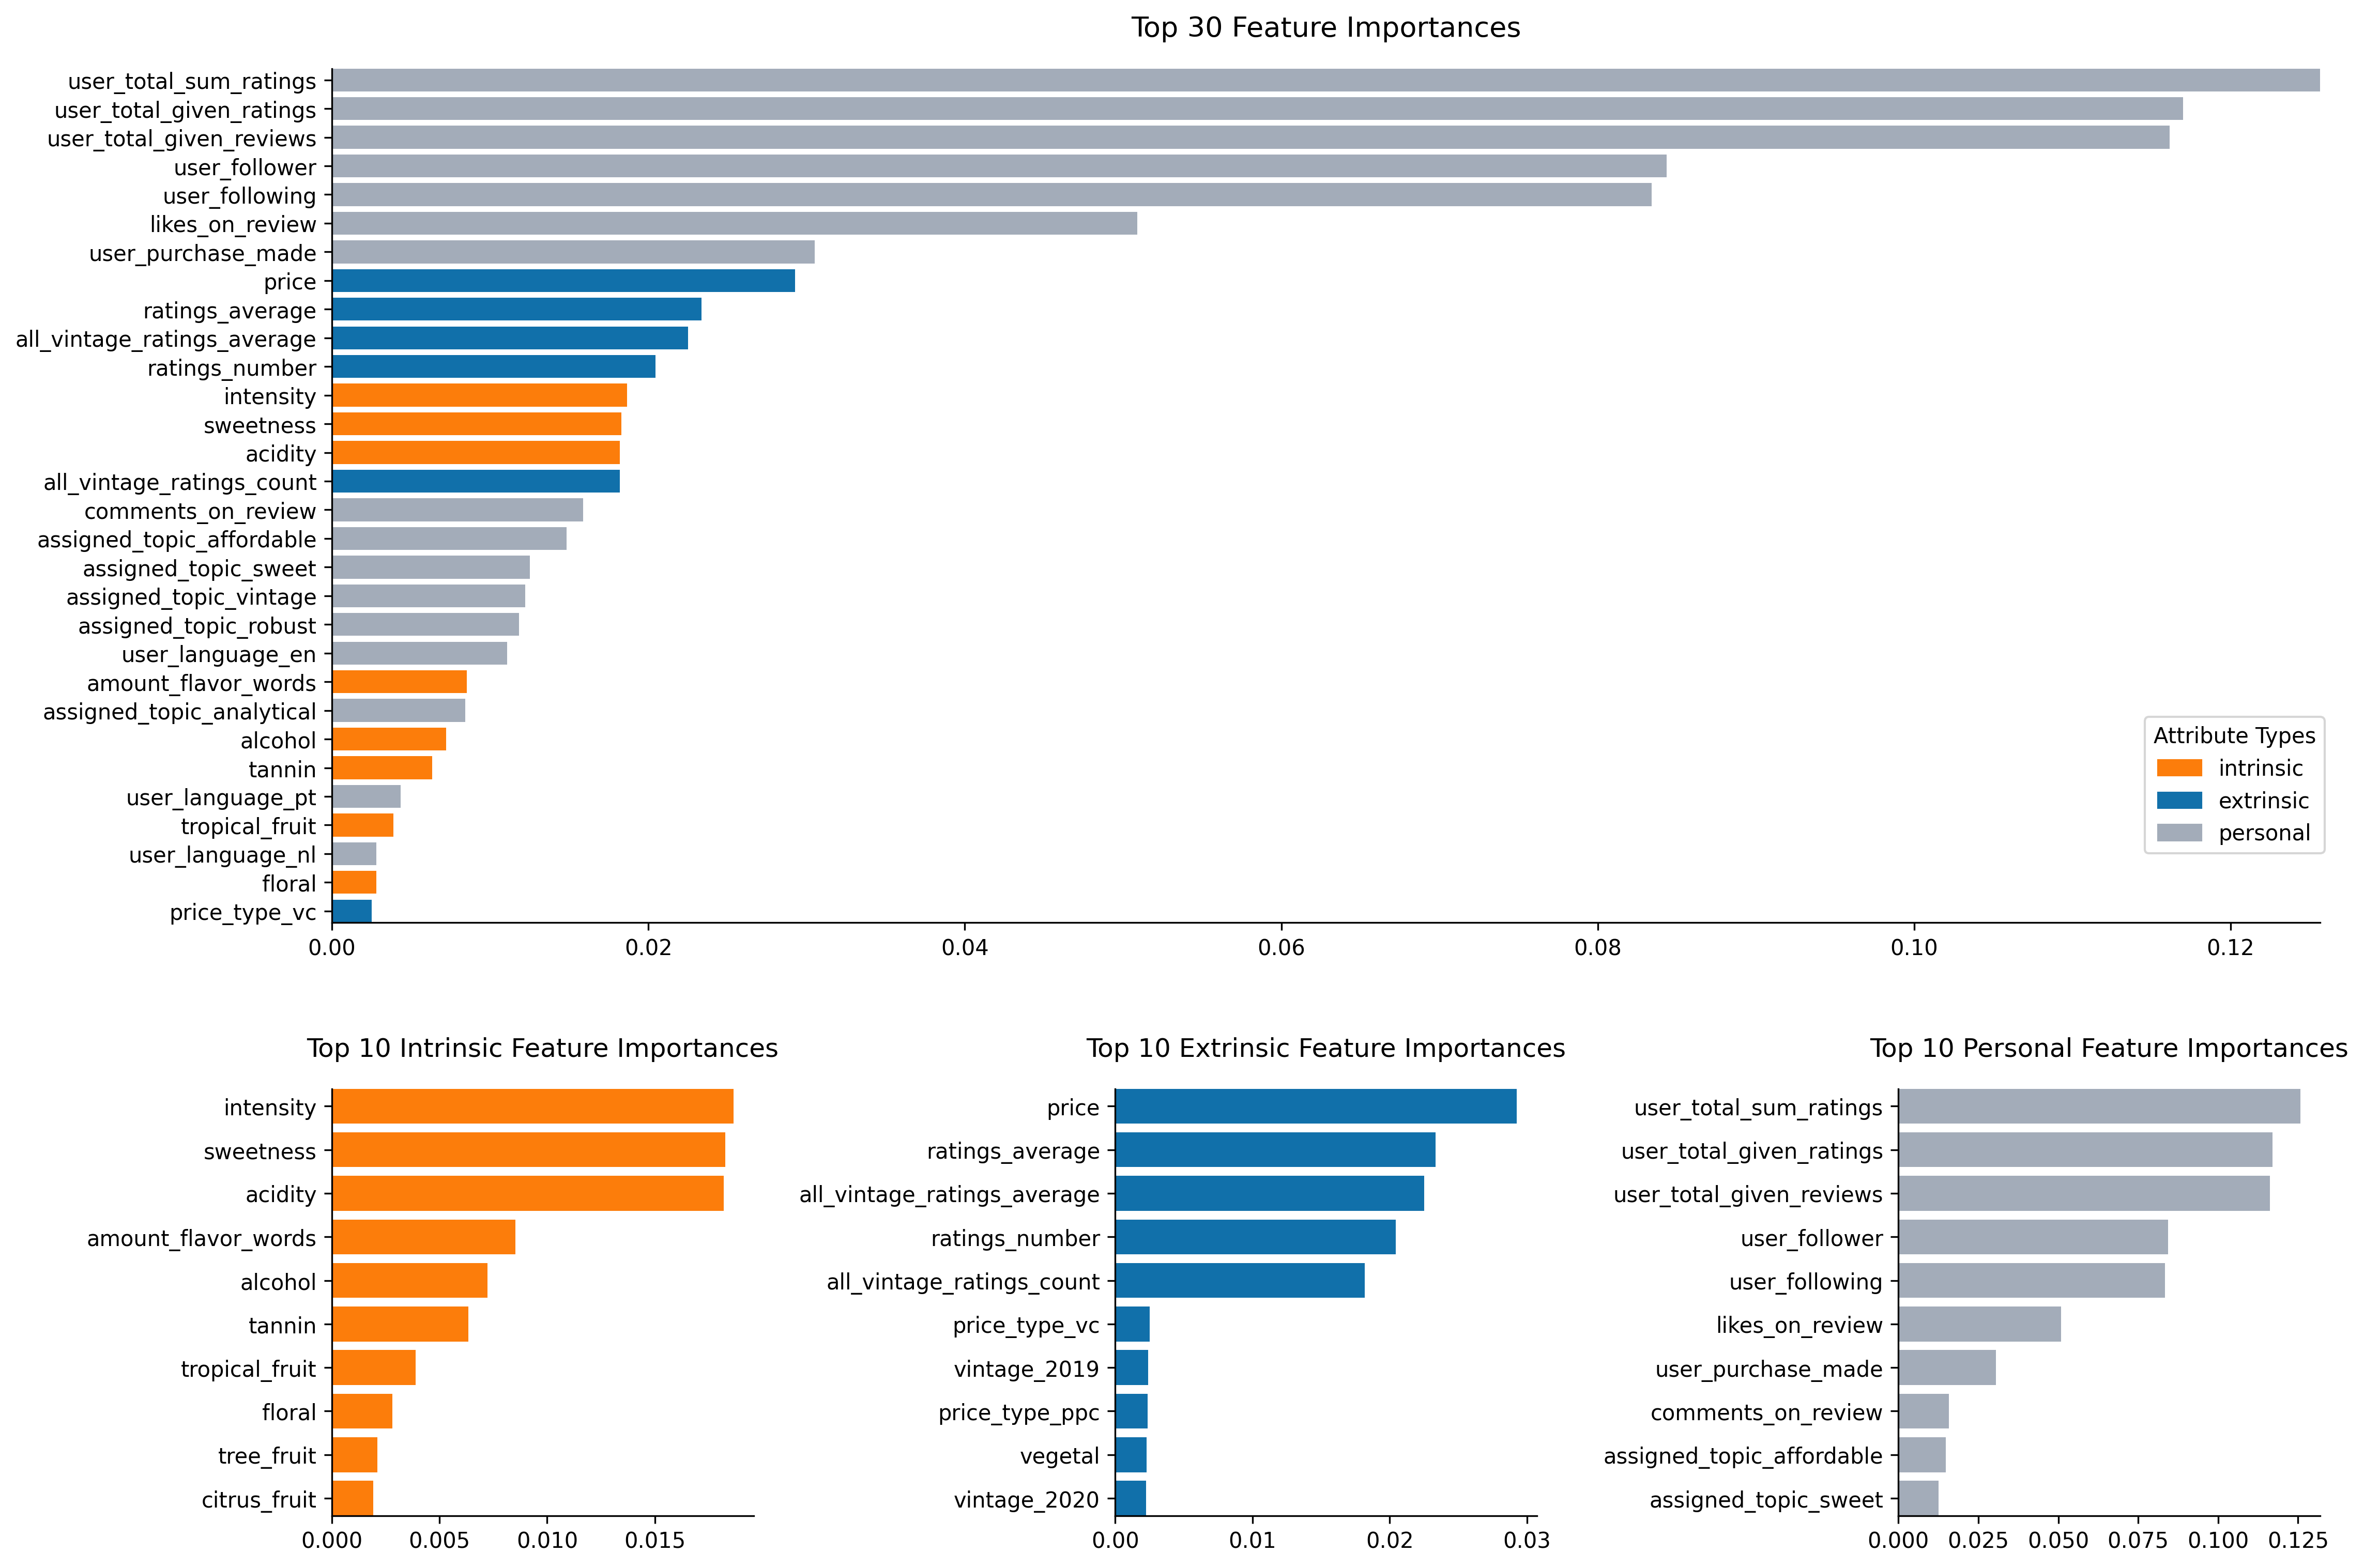

In [44]:
evaluate(rfs)

##### ii. Hypertuning - Optuna

In [38]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [39]:
import optuna
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np


import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score

def objective(trial):
    # Suggested hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 400),
        'max_depth': trial.suggest_int('max_depth', 5, 35),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'criterion': trial.suggest_categorical('criterion', ['entropy']),
        'max_samples': trial.suggest_float('max_samples', 0.1, 1.0),
        'random_state': 0,
    }

    # Creating the RandomForest model
    model = RandomForestClassifier(**params, bootstrap=True)

     # Stratified K-Fold cross-validator
    skf = StratifiedKFold(n_splits=5)

    # Custom scoring function for multi-class ROC AUC
    roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr')

    # Perform cross-validation on the training set
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring=roc_auc_scorer)

    # Average ROC AUC score across all folds
    return scores.mean()

# Early stopping callback
def early_stopping_callback(study, trial):
    if study.best_trial.number + 10 <= trial.number:
        study.stop()

In [188]:
# Create a study and optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, callbacks=[early_stopping_callback])

# Retrieve the best model
best_model = RandomForestClassifier(**study.best_params, random_state=0)
best_model.fit(X_train, y_train)  # Fit on the entire training set

[I 2023-12-16 20:31:31,429] A new study created in memory with name: no-name-f213ea97-ac5b-4ee0-a1b2-c8c2eb5298b6


[I 2023-12-16 20:35:07,701] Trial 0 finished with value: 0.7072630625648572 and parameters: {'n_estimators': 124, 'max_depth': 29, 'min_samples_split': 2, 'max_features': None, 'criterion': 'entropy', 'max_samples': 0.11196932334108359}. Best is trial 0 with value: 0.7072630625648572.
[I 2023-12-16 20:49:09,526] Trial 1 finished with value: 0.7230873288182431 and parameters: {'n_estimators': 258, 'max_depth': 20, 'min_samples_split': 2, 'max_features': None, 'criterion': 'entropy', 'max_samples': 0.21547944148102327}. Best is trial 1 with value: 0.7230873288182431.
[I 2023-12-16 21:10:45,120] Trial 2 finished with value: 0.7094766986650164 and parameters: {'n_estimators': 148, 'max_depth': 34, 'min_samples_split': 3, 'max_features': None, 'criterion': 'entropy', 'max_samples': 0.7481148196118886}. Best is trial 1 with value: 0.7230873288182431.
[I 2023-12-16 21:26:16,618] Trial 3 finished with value: 0.7323814942850351 and parameters: {'n_estimators': 116, 'max_depth': 19, 'min_samples

RandomForestClassifier(criterion='entropy', max_depth=9, max_features=None,
                       max_samples=0.7095660736174616, min_samples_split=16,
                       n_estimators=105, random_state=0)

Train accuracy: 0.49707216053129577

Test accuracy: 0.4715707918523764

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       130
           1       0.00      0.00      0.00        60
           2       0.00      0.00      0.00       326
           3       0.00      0.00      0.00       445
           4       0.28      0.00      0.00      2249
           5       0.39      0.27      0.32      4454
           6       0.49      0.86      0.62     10477
           7       0.45      0.20      0.28      3395
           8       0.48      0.15      0.22      2471

    accuracy                           0.47     24007
   macro avg       0.23      0.17      0.16     24007
weighted avg       0.42      0.47      0.39     24007




c:\Users\lukas\anaconda3\envs\py311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lukas\anaconda3\envs\py311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lukas\anaconda3\envs\py311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


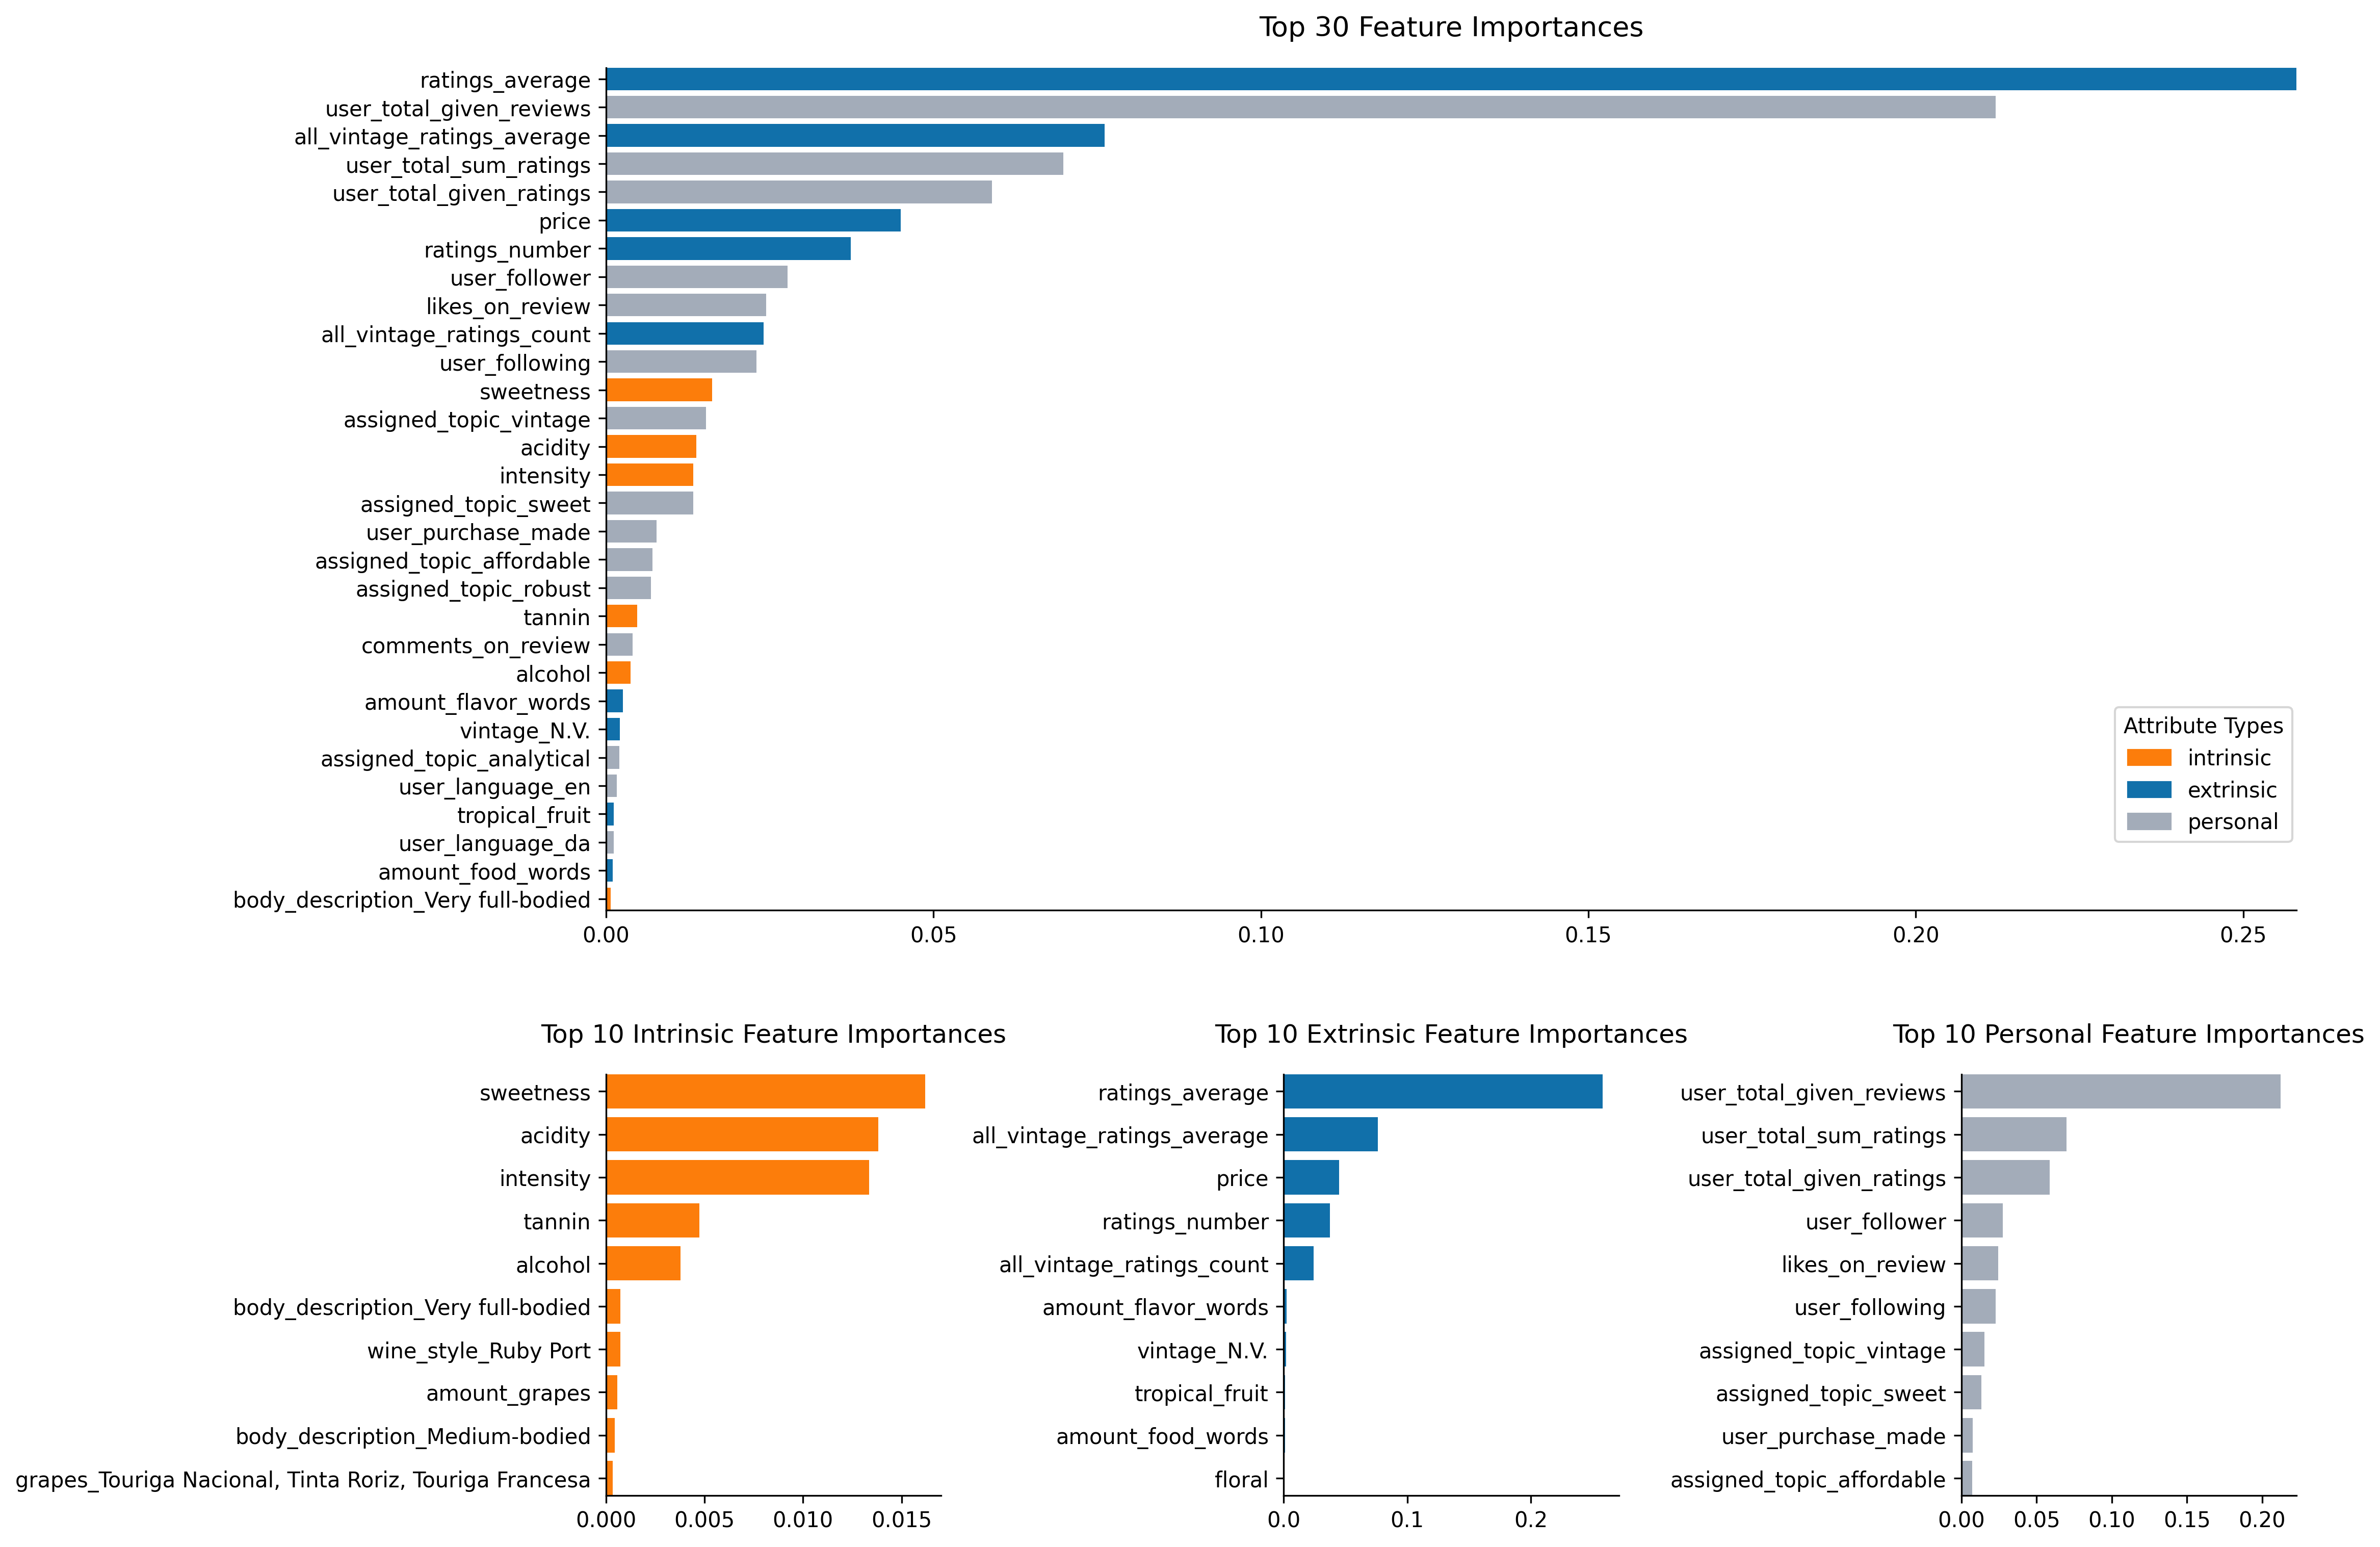

In [189]:
evaluate(best_model)

In [190]:
# Specify the directory name where you want to save the model
model_dir = 'Model'

# Save your model to a file within the directory
model_path = os.path.join(model_dir, 'random_forest_model.joblib')
dump(best_model, model_path)

['Model\\random_forest_model.joblib']

In [46]:
# Specify the directory name where you want to save the model
model_dir = 'Model'

model_path = os.path.join(model_dir, 'random_forest_model.joblib')

rfs_loaded = load(model_path)

Train accuracy: 0.49707216053129577

Test accuracy: 0.4715707918523764

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       130
           1       0.00      0.00      0.00        60
           2       0.00      0.00      0.00       326
           3       0.00      0.00      0.00       445
           4       0.28      0.00      0.00      2249
           5       0.39      0.27      0.32      4454
           6       0.49      0.86      0.62     10477
           7       0.45      0.20      0.28      3395
           8       0.48      0.15      0.22      2471

    accuracy                           0.47     24007
   macro avg       0.23      0.17      0.16     24007
weighted avg       0.42      0.47      0.39     24007




c:\Users\lukas\anaconda3\envs\py311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lukas\anaconda3\envs\py311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lukas\anaconda3\envs\py311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


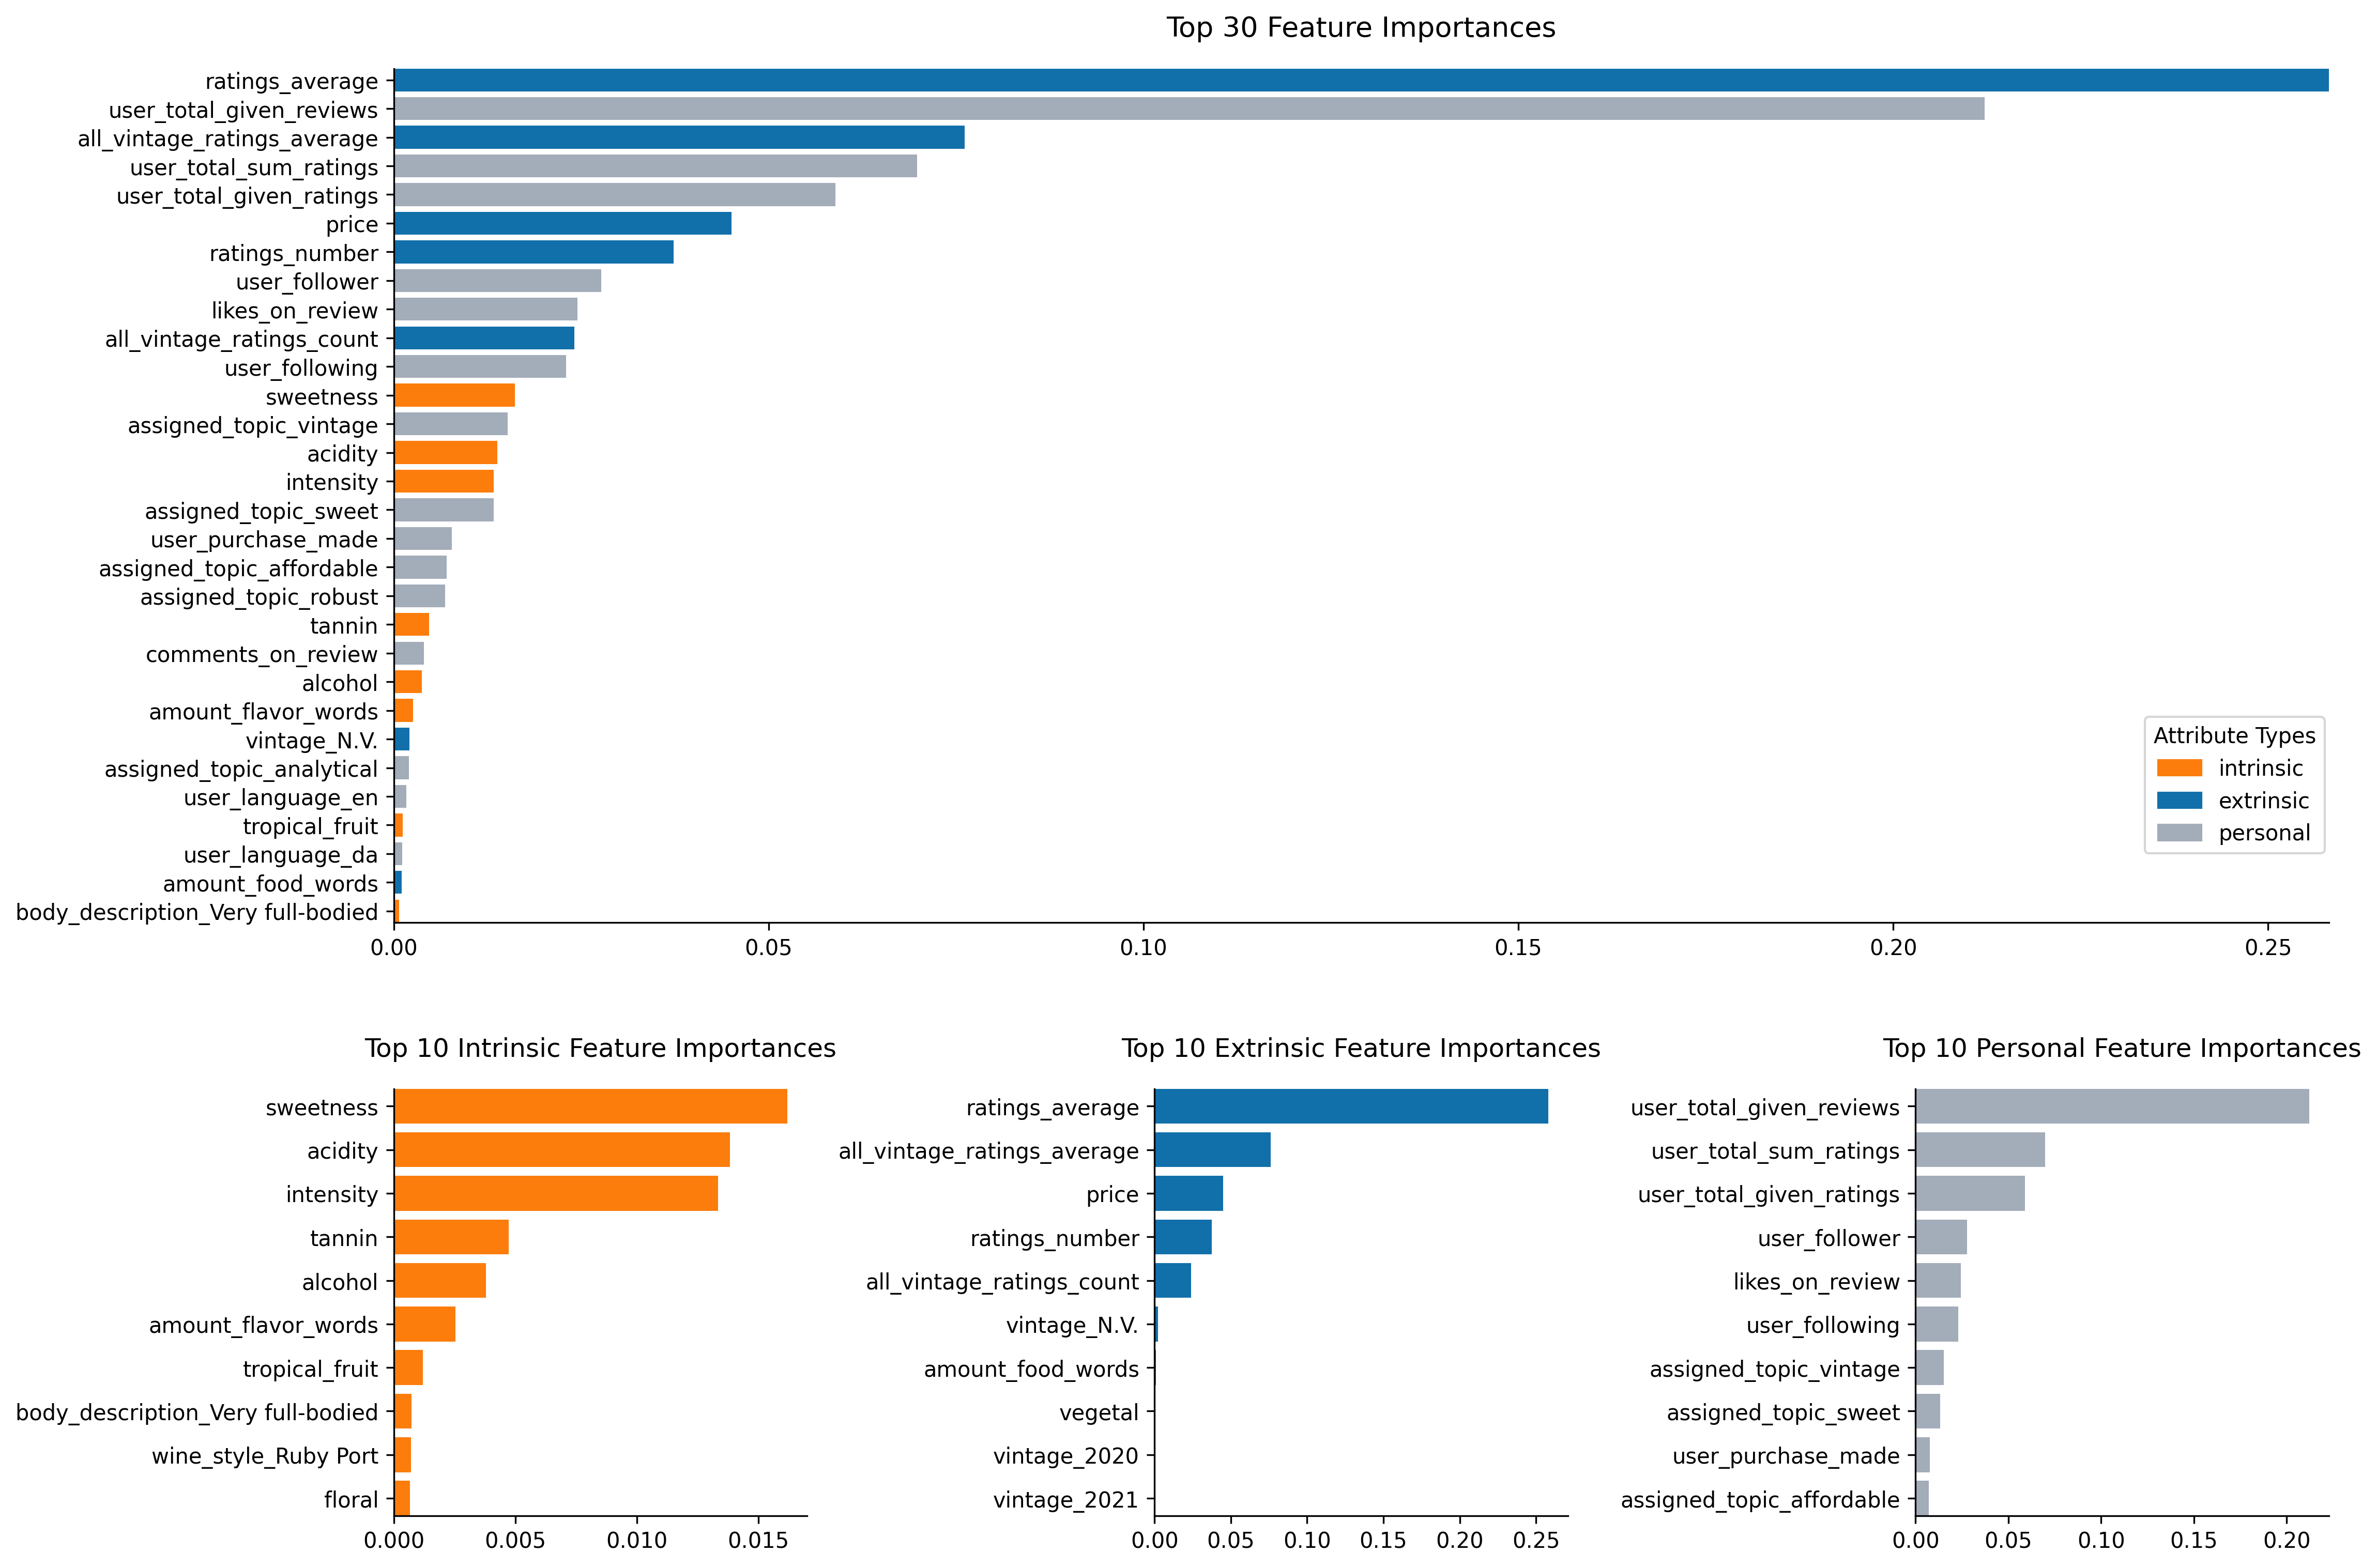

In [47]:
evaluate(rfs_loaded)

In [48]:
# Make predictions on the test set
y_pred_proba = rfs_loaded.predict_proba(X_test)  # Get probabilities for each class

# Calculate the ROC AUC score for multiclass classification
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

print(f"ROC AUC Score on Test Set: {roc_auc}")

ROC AUC Score on Test Set: 0.7509784012130392


#### ii. AdaBoost

##### a. simple

In [49]:
# Import the AdaBoost classifier
from sklearn.ensemble import AdaBoostClassifier

abc = AdaBoostClassifier(random_state=0)

# Train AdaBoost Classifier
abc.fit(X_train, y_train)

AdaBoostClassifier(random_state=0)

In [50]:
# Make predictions on the test set
y_pred_proba = abc.predict_proba(X_test)  # Get probabilities for each class

# Calculate the ROC AUC score for multiclass classification
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

print(f"ROC AUC Score on Test Set: {roc_auc}")

ROC AUC Score on Test Set: 0.659968152825717


Train accuracy: 0.46102760024279643

Test accuracy: 0.45645020202440956

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       130
           1       0.00      0.00      0.00        60
           2       0.00      0.00      0.00       326
           3       0.00      0.00      0.00       445
           4       0.20      0.01      0.01      2249
           5       0.38      0.21      0.27      4454
           6       0.48      0.87      0.62     10477
           7       0.35      0.15      0.21      3395
           8       0.43      0.14      0.21      2471

    accuracy                           0.46     24007
   macro avg       0.20      0.15      0.15     24007
weighted avg       0.39      0.46      0.37     24007




c:\Users\lukas\anaconda3\envs\py311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lukas\anaconda3\envs\py311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lukas\anaconda3\envs\py311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lukas\anacond

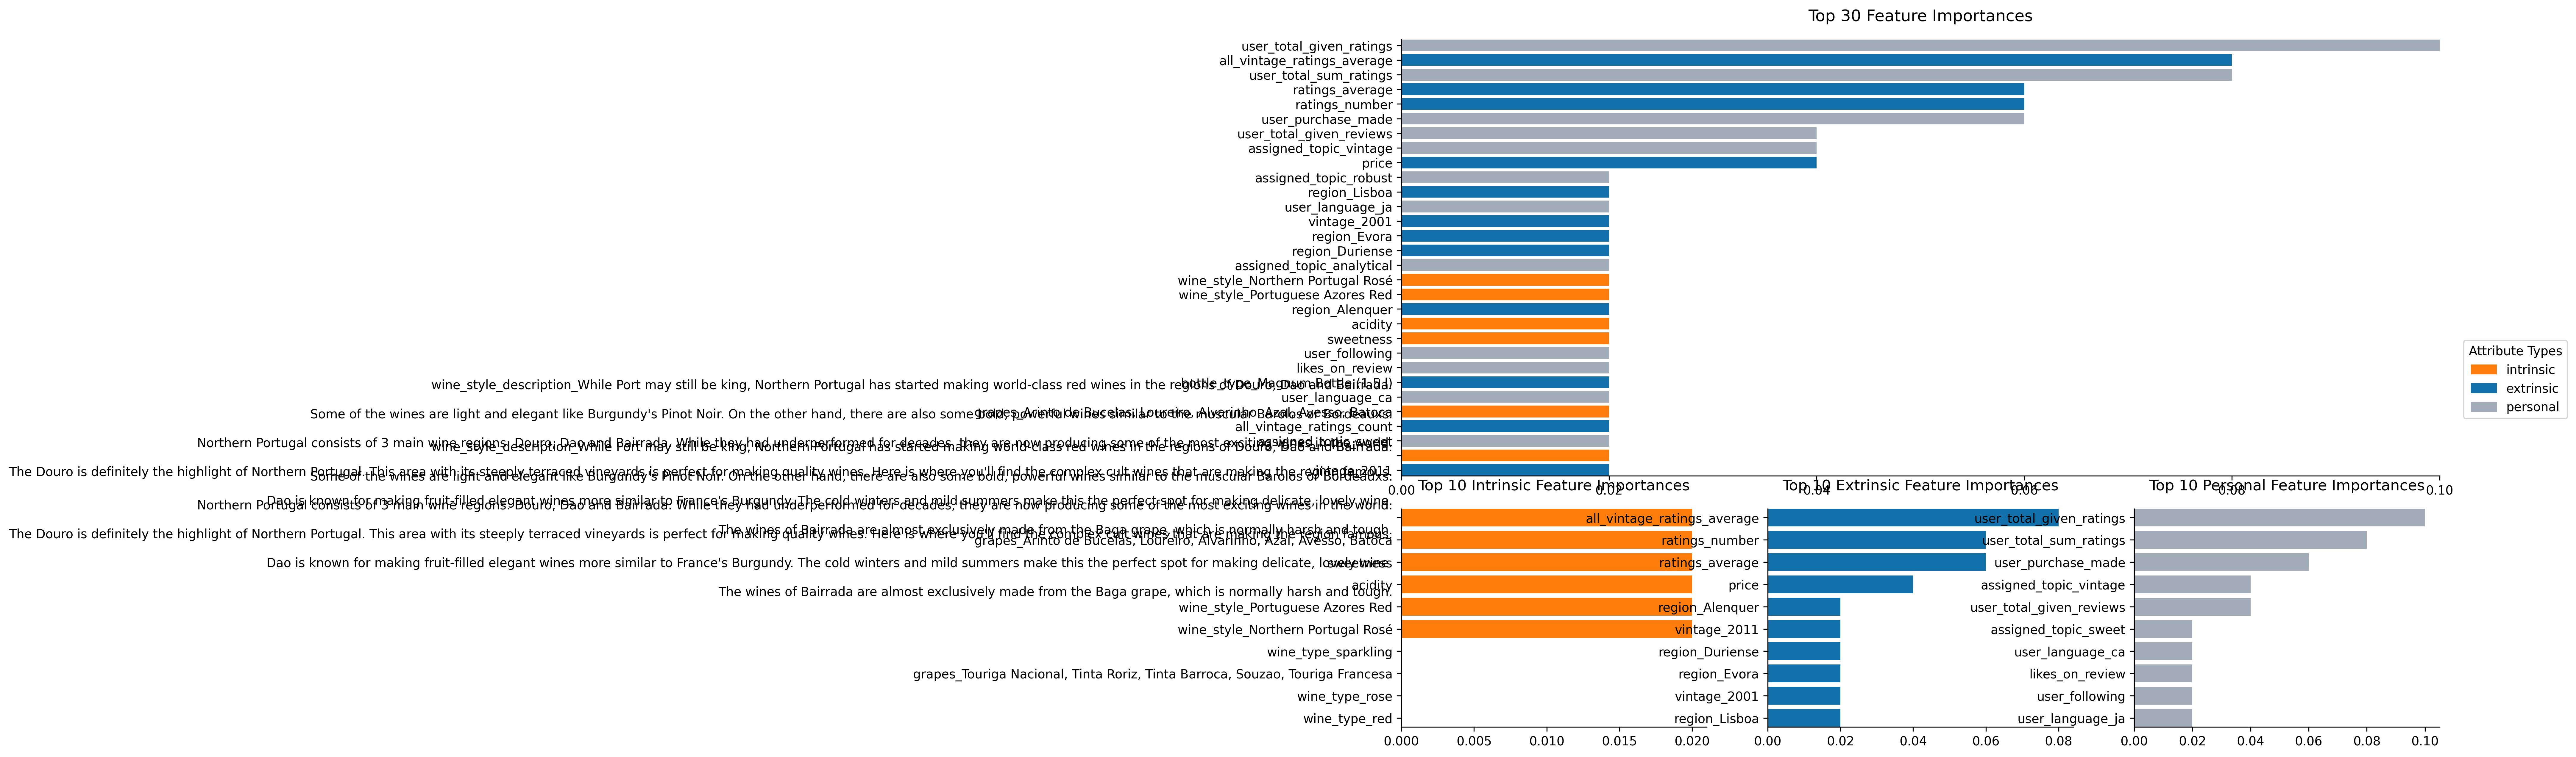

In [51]:
evaluate(abc)

##### b. Hypertuning

<!-- #### b. Hypertuning -->

In [83]:
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, make_scorer

def objective(trial):
    # Suggested hyperparameters for AdaBoost
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 200),
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 0.5),
        'estimator': DecisionTreeClassifier(
            max_depth=trial.suggest_int('base_estimator_max_depth', 1, 10),
            min_samples_split=trial.suggest_int('min_samples_split', 2, 20)
        ),
        'algorithm': trial.suggest_categorical('algorithm', ['SAMME', 'SAMME.R']),
        'random_state': 0
    }

    # Creating the AdaBoost model
    model = AdaBoostClassifier(**params)

    # Stratified K-Fold cross-validator
    skf = StratifiedKFold(n_splits=5)

    # Stratified K-Fold cross-validator
    skf = StratifiedKFold(n_splits=5)

    # Custom scoring function for multi-class ROC AUC
    roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr')

    # Perform cross-validation on the training set
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring=roc_auc_scorer)

    # Average ROC AUC score across all folds
    return scores.mean()

# Early stopping callback
def early_stopping_callback(study, trial):
    if study.best_trial.number + 10 <= trial.number:
        study.stop()


In [84]:
# Create a study and optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, callbacks=[early_stopping_callback])

# Retrieve the best model
ada_model = AdaBoostClassifier(**study.best_params, random_state=0)
ada_model.fit(X_train, y_train)  # Fit on the entire training set

[I 2023-12-18 09:00:38,779] A new study created in memory with name: no-name-fdd2831e-824b-4968-8606-01244a815993
[I 2023-12-18 09:17:42,564] Trial 0 finished with value: 0.6759839354831396 and parameters: {'n_estimators': 78, 'learning_rate': 0.36118405255845654, 'base_estimator_max_depth': 10, 'min_samples_split': 13, 'algorithm': 'SAMME.R'}. Best is trial 0 with value: 0.6759839354831396.
[I 2023-12-18 09:24:51,991] Trial 1 finished with value: 0.6342418002659806 and parameters: {'n_estimators': 68, 'learning_rate': 0.2221790583302329, 'base_estimator_max_depth': 5, 'min_samples_split': 4, 'algorithm': 'SAMME.R'}. Best is trial 0 with value: 0.6759839354831396.
[I 2023-12-18 09:30:26,026] Trial 2 finished with value: 0.7282574677001811 and parameters: {'n_estimators': 106, 'learning_rate': 0.2440829088924594, 'base_estimator_max_depth': 2, 'min_samples_split': 4, 'algorithm': 'SAMME'}. Best is trial 2 with value: 0.7282574677001811.
[I 2023-12-18 09:40:37,319] Trial 3 finished with 

TypeError: AdaBoostClassifier.__init__() got an unexpected keyword argument 'base_estimator_max_depth'

In [86]:
study.best_params

{'n_estimators': 143,
 'learning_rate': 0.1472762258376996,
 'base_estimator_max_depth': 8,
 'min_samples_split': 6,
 'algorithm': 'SAMME'}

In [87]:
study_best_params = {'n_estimators': 143,
 'learning_rate': 0.1472762258376996,
 'base_estimator_max_depth': 8,
 'min_samples_split': 6,
 'algorithm': 'SAMME'}

# Create a DecisionTreeClassifier with the max_depth from the best parameters
decision_tree = DecisionTreeClassifier(max_depth=study_best_params['base_estimator_max_depth'])

# Create the AdaBoostClassifier with the decision tree as the base estimator
# and other parameters from the study
ada_model = AdaBoostClassifier(
    base_estimator=decision_tree,
    n_estimators=study_best_params['n_estimators'],
    learning_rate=study_best_params['learning_rate'],
    random_state=0
)

ada_model.fit(X_train, y_train)  # Fit on the entire training set

c:\Users\lukas\anaconda3\envs\py311\Lib\site-packages\sklearn\ensemble\_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=8),
                   learning_rate=0.1472762258376996, n_estimators=143,
                   random_state=0)

In [88]:
# Make predictions on the test set
y_pred_proba = ada_model.predict_proba(X_test)  # Get probabilities for each class

# Calculate the ROC AUC score for multiclass classification
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

print(f"ROC AUC Score on Test Set: {roc_auc}")

ROC AUC Score on Test Set: 0.6624527232412708


Train accuracy: 0.46950762309422645

Test accuracy: 0.46532261423751403

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       130
           1       0.00      0.00      0.00        60
           2       0.00      0.00      0.00       326
           3       0.50      0.00      0.00       445
           4       0.26      0.02      0.03      2249
           5       0.40      0.26      0.32      4454
           6       0.48      0.89      0.62     10477
           7       0.41      0.11      0.17      3395
           8       0.52      0.10      0.17      2471

    accuracy                           0.47     24007
   macro avg       0.28      0.15      0.15     24007
weighted avg       0.43      0.47      0.37     24007




c:\Users\lukas\anaconda3\envs\py311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lukas\anaconda3\envs\py311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lukas\anaconda3\envs\py311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


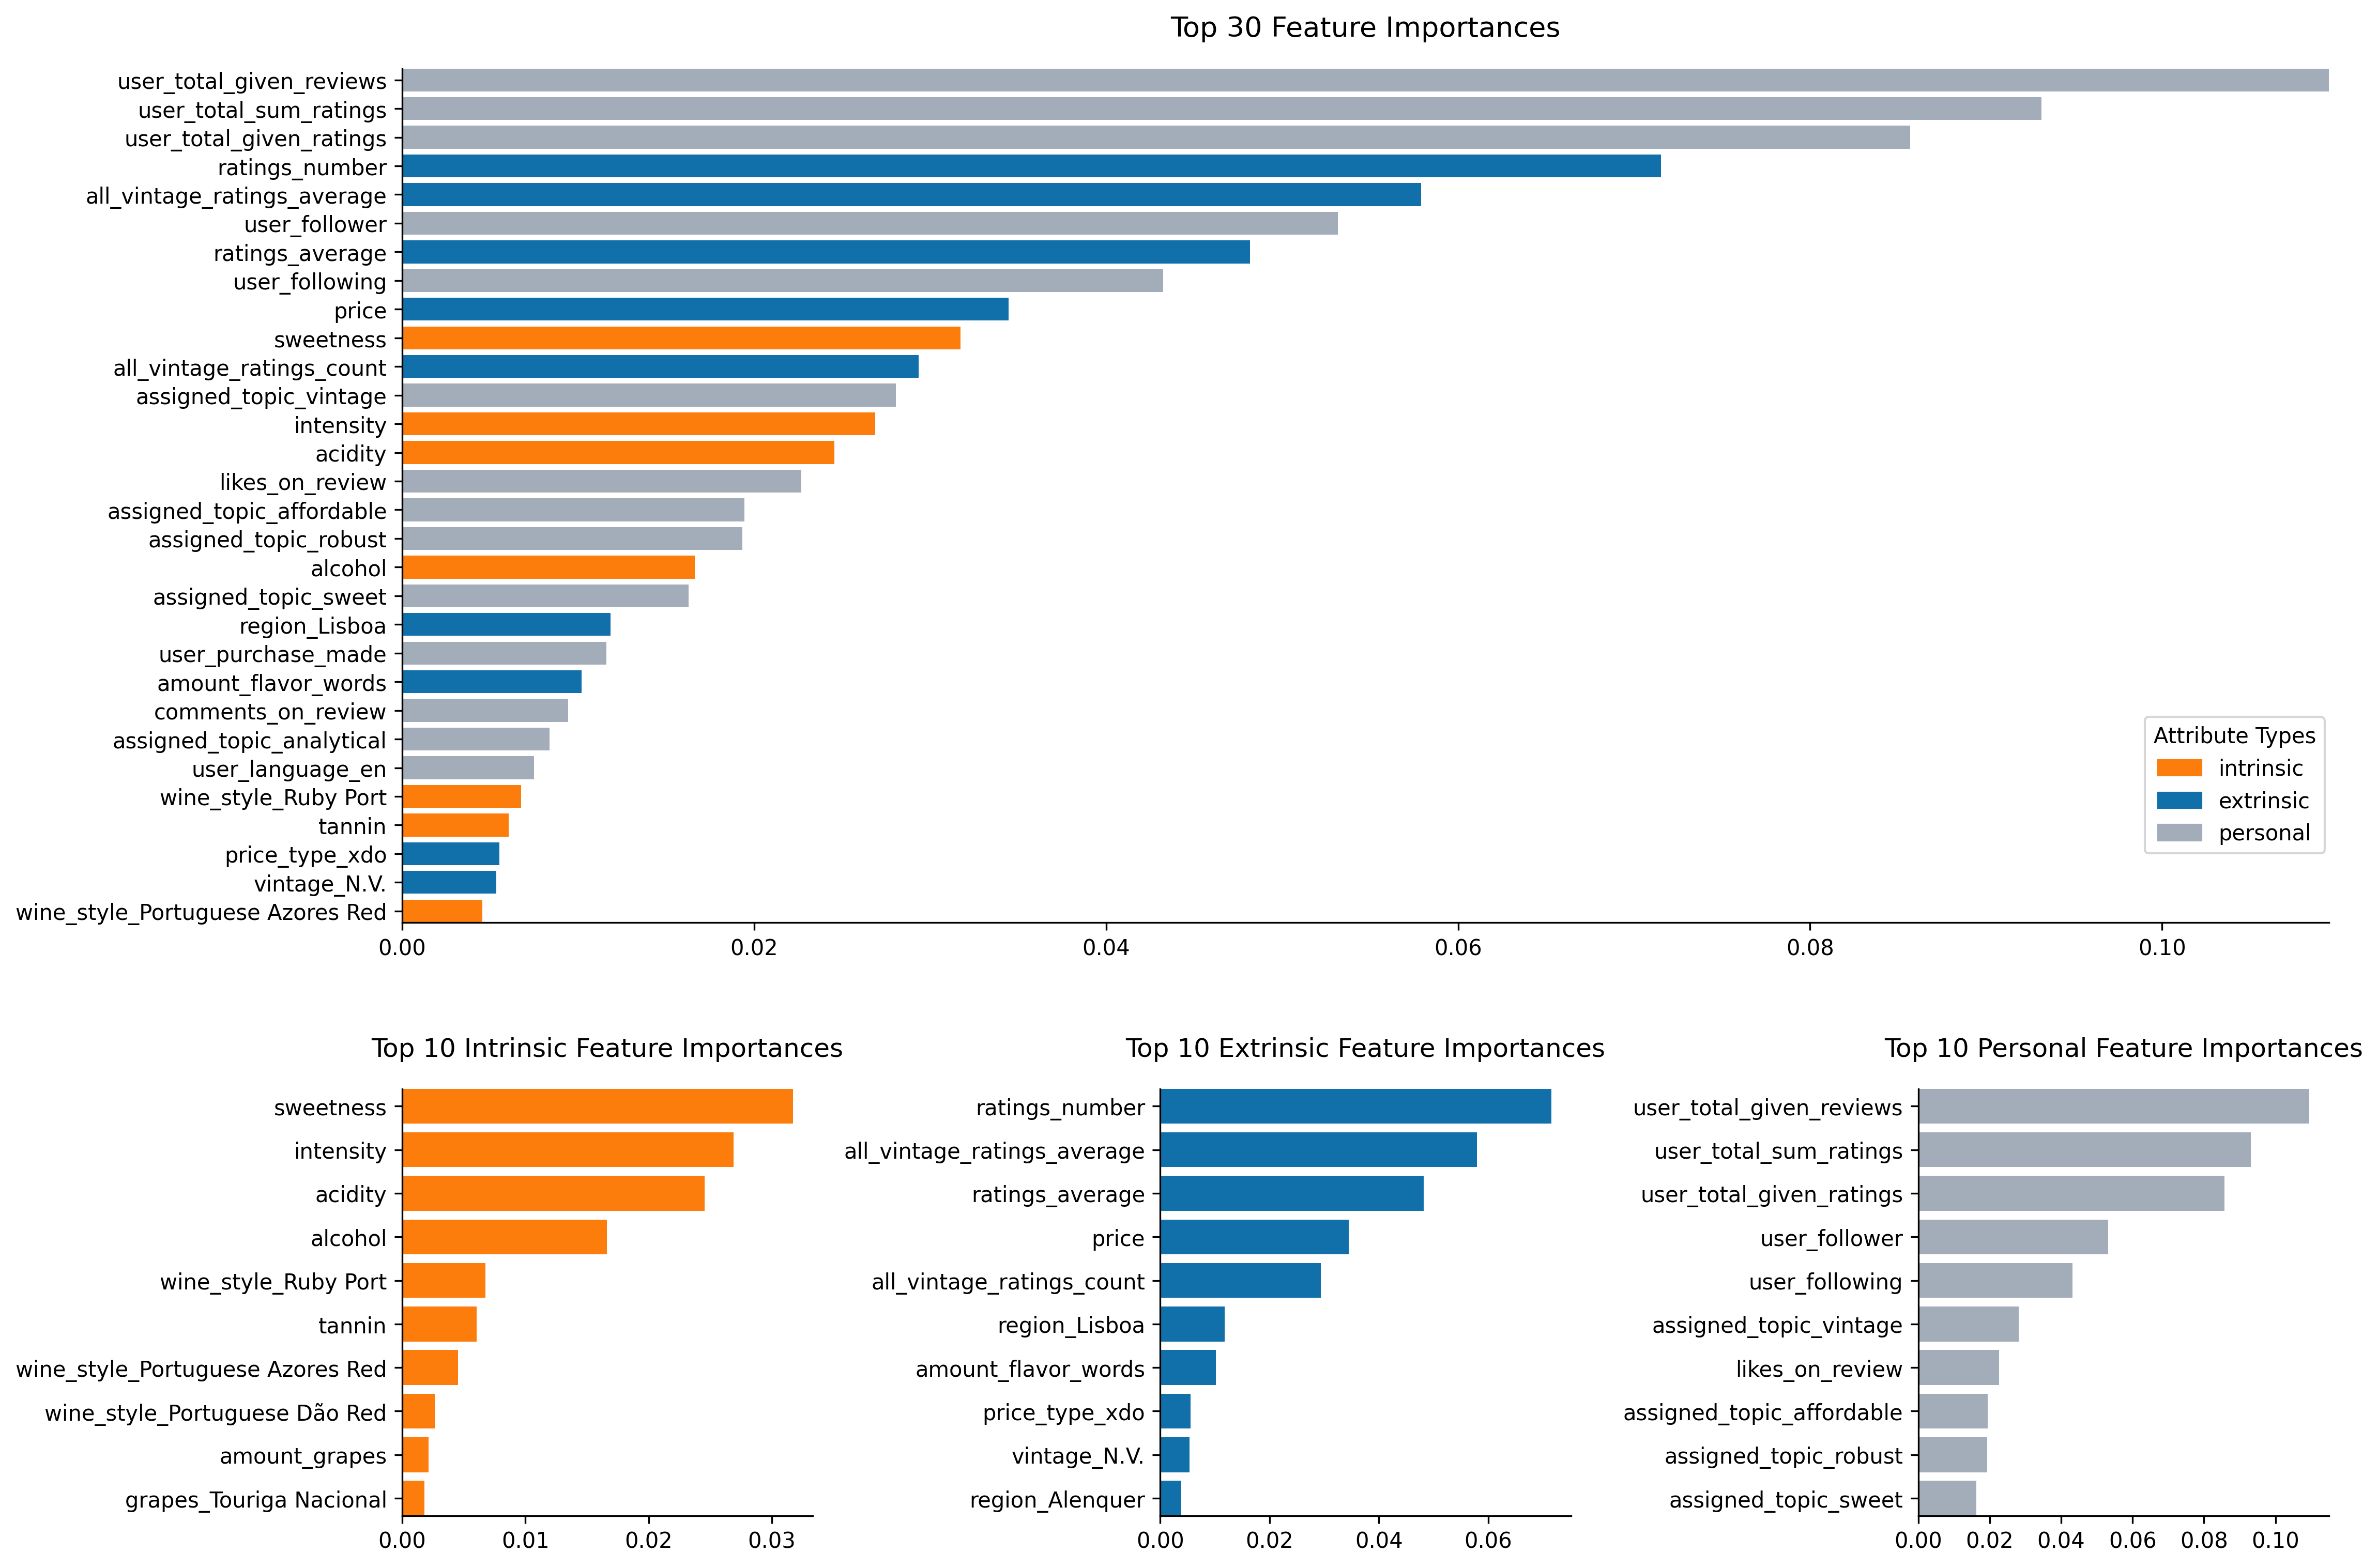

In [47]:
evaluate(ada_model)

In [102]:
# Import optuna.visualization
import optuna.visualization as vis

# Plot optimization history
vis.plot_optimization_history(study)

# Plot parameter importance
vis.plot_param_importances(study)

In [48]:
# Specify the directory name where you want to save the model
model_dir = 'Model'

# Save your model to a file within the directory
model_path = os.path.join(model_dir, 'ada_model.joblib')
dump(ada_model, model_path)

['Model\\ada_model.joblib']

In [52]:
# Specify the directory name where you want to save the model
model_dir = 'Model'

model_path = os.path.join(model_dir, 'ada_model.joblib')

ada_loaded = load(model_path)

Train accuracy: 0.46950762309422645

Test accuracy: 0.46532261423751403

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       130
           1       0.00      0.00      0.00        60
           2       0.00      0.00      0.00       326
           3       0.50      0.00      0.00       445
           4       0.26      0.02      0.03      2249
           5       0.40      0.26      0.32      4454
           6       0.48      0.89      0.62     10477
           7       0.41      0.11      0.17      3395
           8       0.52      0.10      0.17      2471

    accuracy                           0.47     24007
   macro avg       0.28      0.15      0.15     24007
weighted avg       0.43      0.47      0.37     24007




c:\Users\lukas\anaconda3\envs\py311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lukas\anaconda3\envs\py311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lukas\anaconda3\envs\py311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


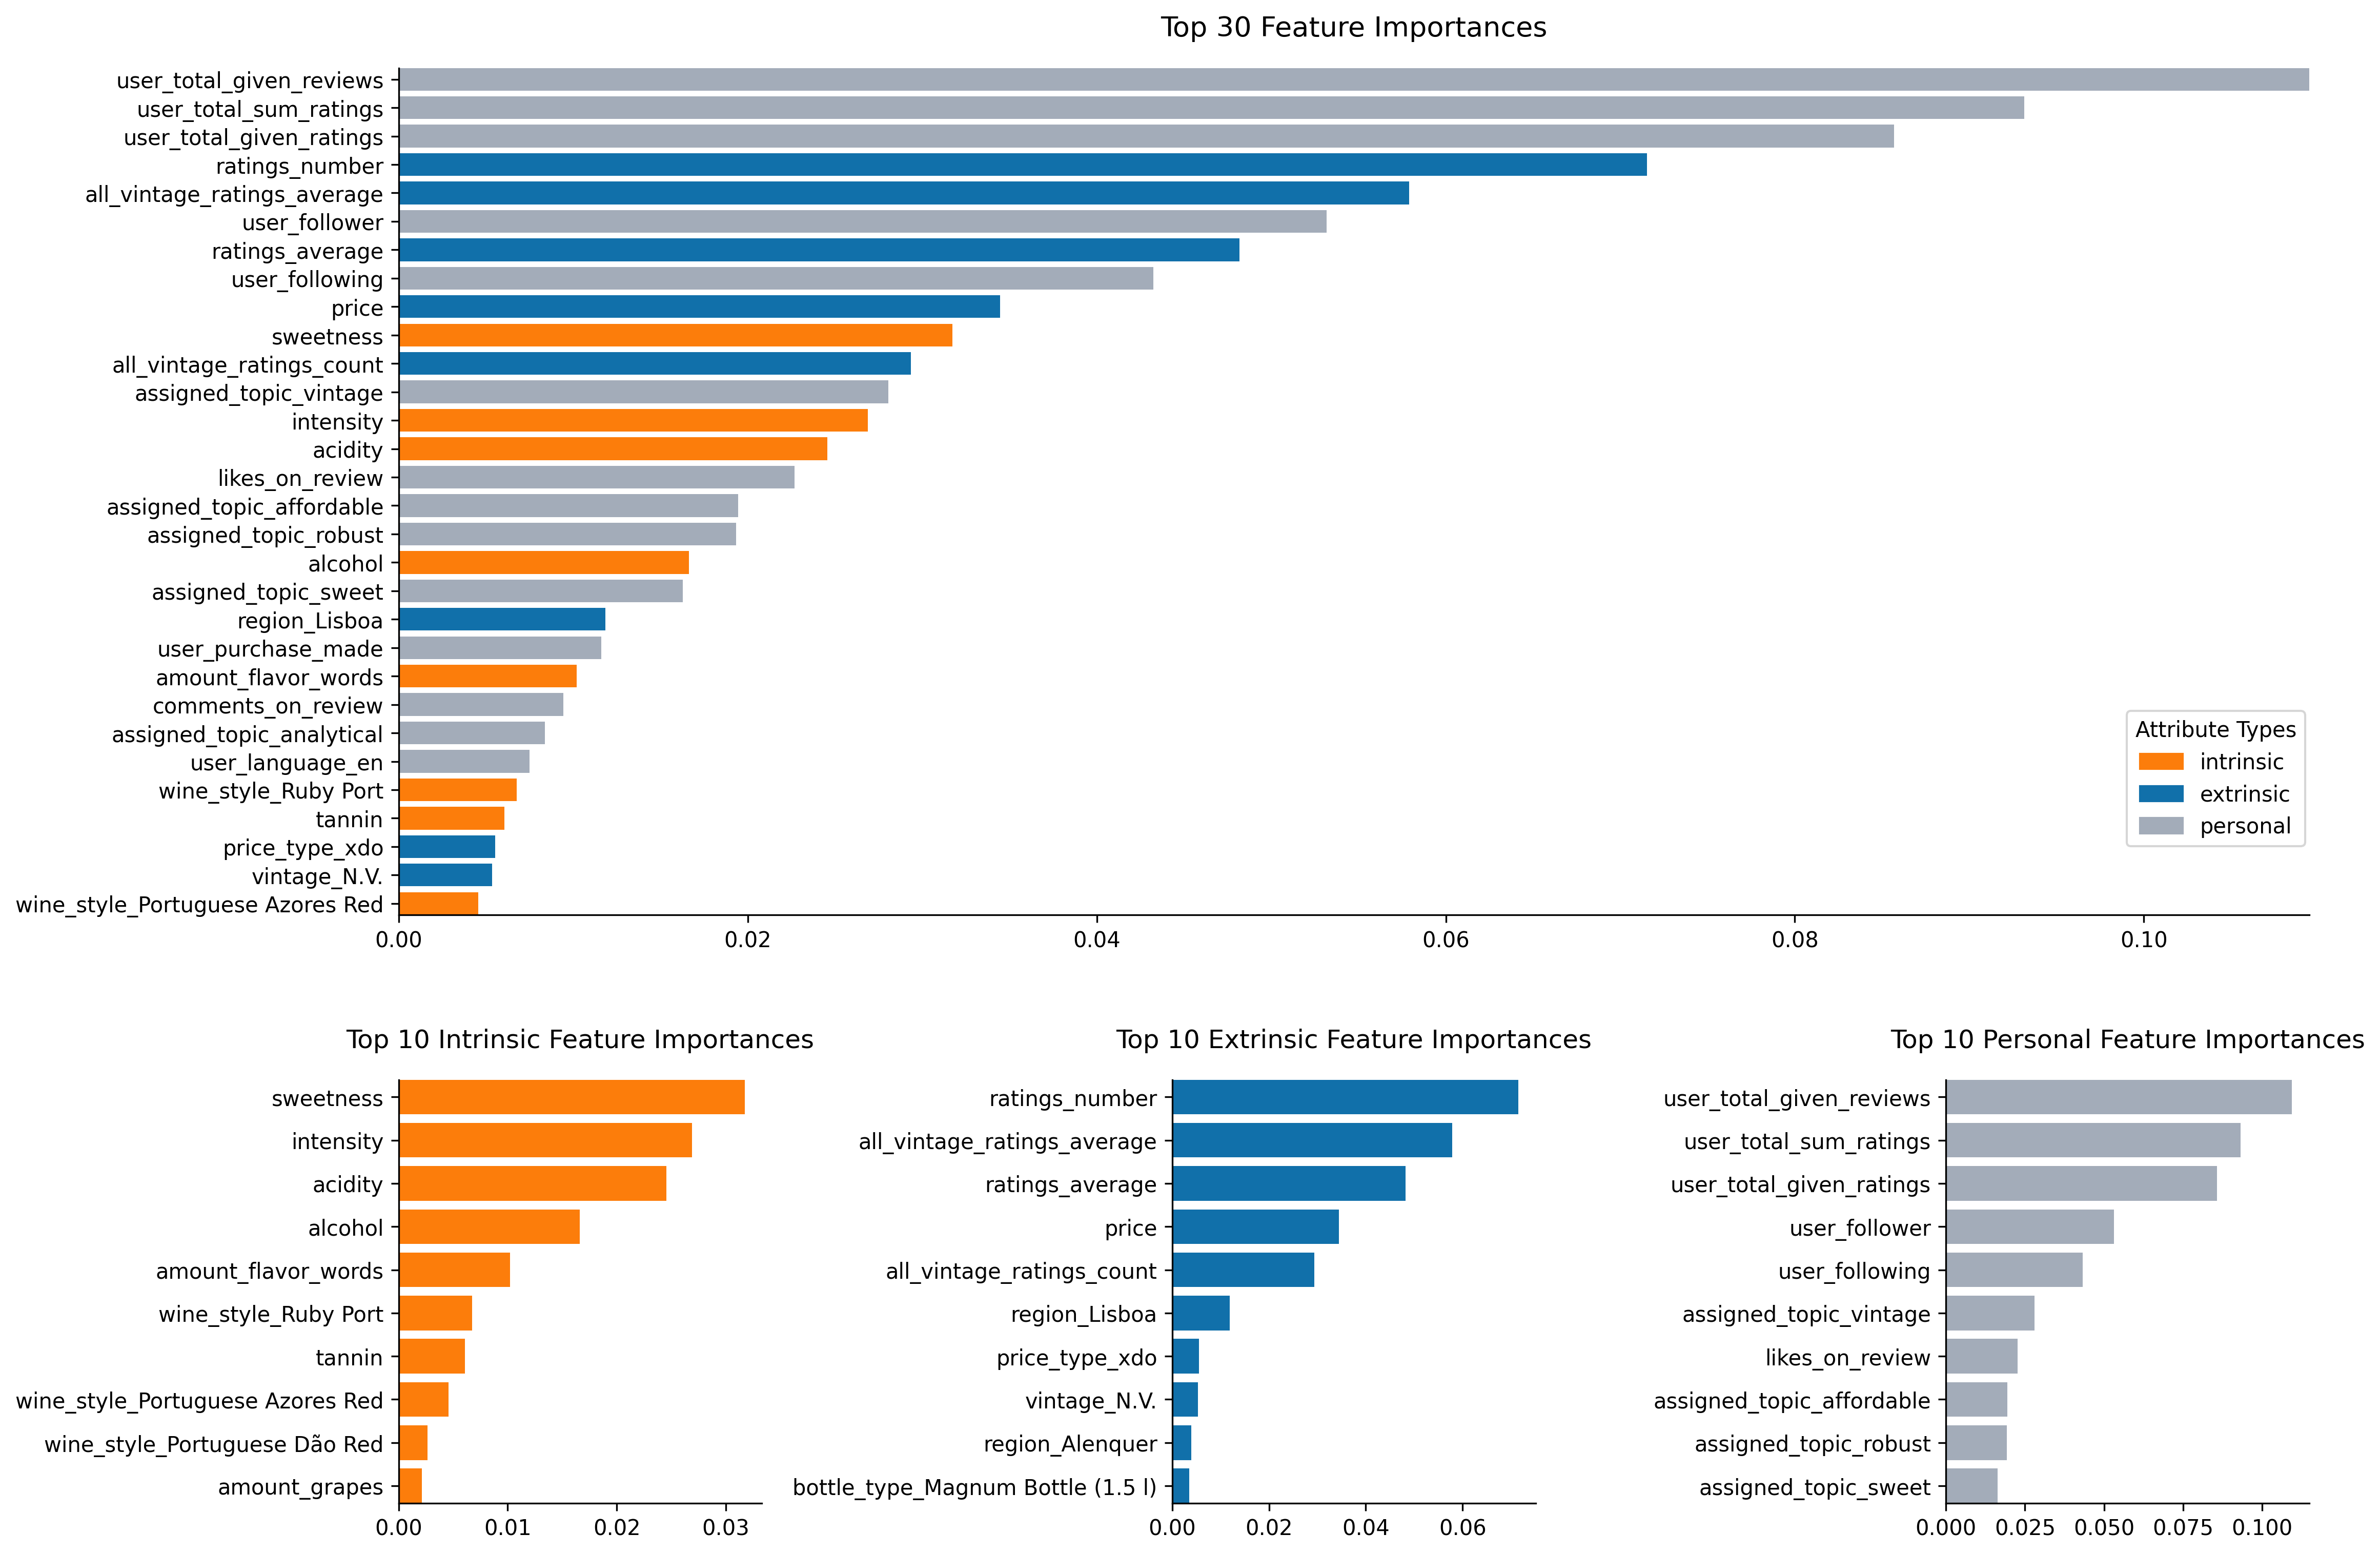

In [54]:
evaluate(ada_loaded)

In [53]:
# Make predictions on the test set
y_pred_proba = ada_loaded.predict_proba(X_test)  # Get probabilities for each class

# Calculate the ROC AUC score for multiclass classification
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

print(f"ROC AUC Score on Test Set: {roc_auc}")

ROC AUC Score on Test Set: 0.6574548394490823


#### iii. Gradient Boosting

##### a. simple

In [55]:
# Instantiate gbc (GradientBoostingClassifier)
gbc = GradientBoostingClassifier()

# Fit gbc to the training set
gbc.fit(X_train, y_train)

GradientBoostingClassifier()

In [56]:
# Make predictions on the test set
y_pred_proba = gbc.predict_proba(X_test)  # Get probabilities for each class

# Calculate the ROC AUC score for multiclass classification
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

print(f"ROC AUC Score on Test Set: {roc_auc}")

ROC AUC Score on Test Set: 0.7461866216305006


Train accuracy: 0.5027136073124576

Test accuracy: 0.4687799391844045

              precision    recall  f1-score   support

           0       0.07      0.01      0.01       130
           1       0.00      0.00      0.00        60
           2       0.00      0.00      0.00       326
           3       0.15      0.01      0.01       445
           4       0.27      0.03      0.06      2249
           5       0.39      0.27      0.32      4454
           6       0.49      0.85      0.62     10477
           7       0.44      0.19      0.27      3395
           8       0.47      0.16      0.24      2471

    accuracy                           0.47     24007
   macro avg       0.25      0.17      0.17     24007
weighted avg       0.42      0.47      0.40     24007




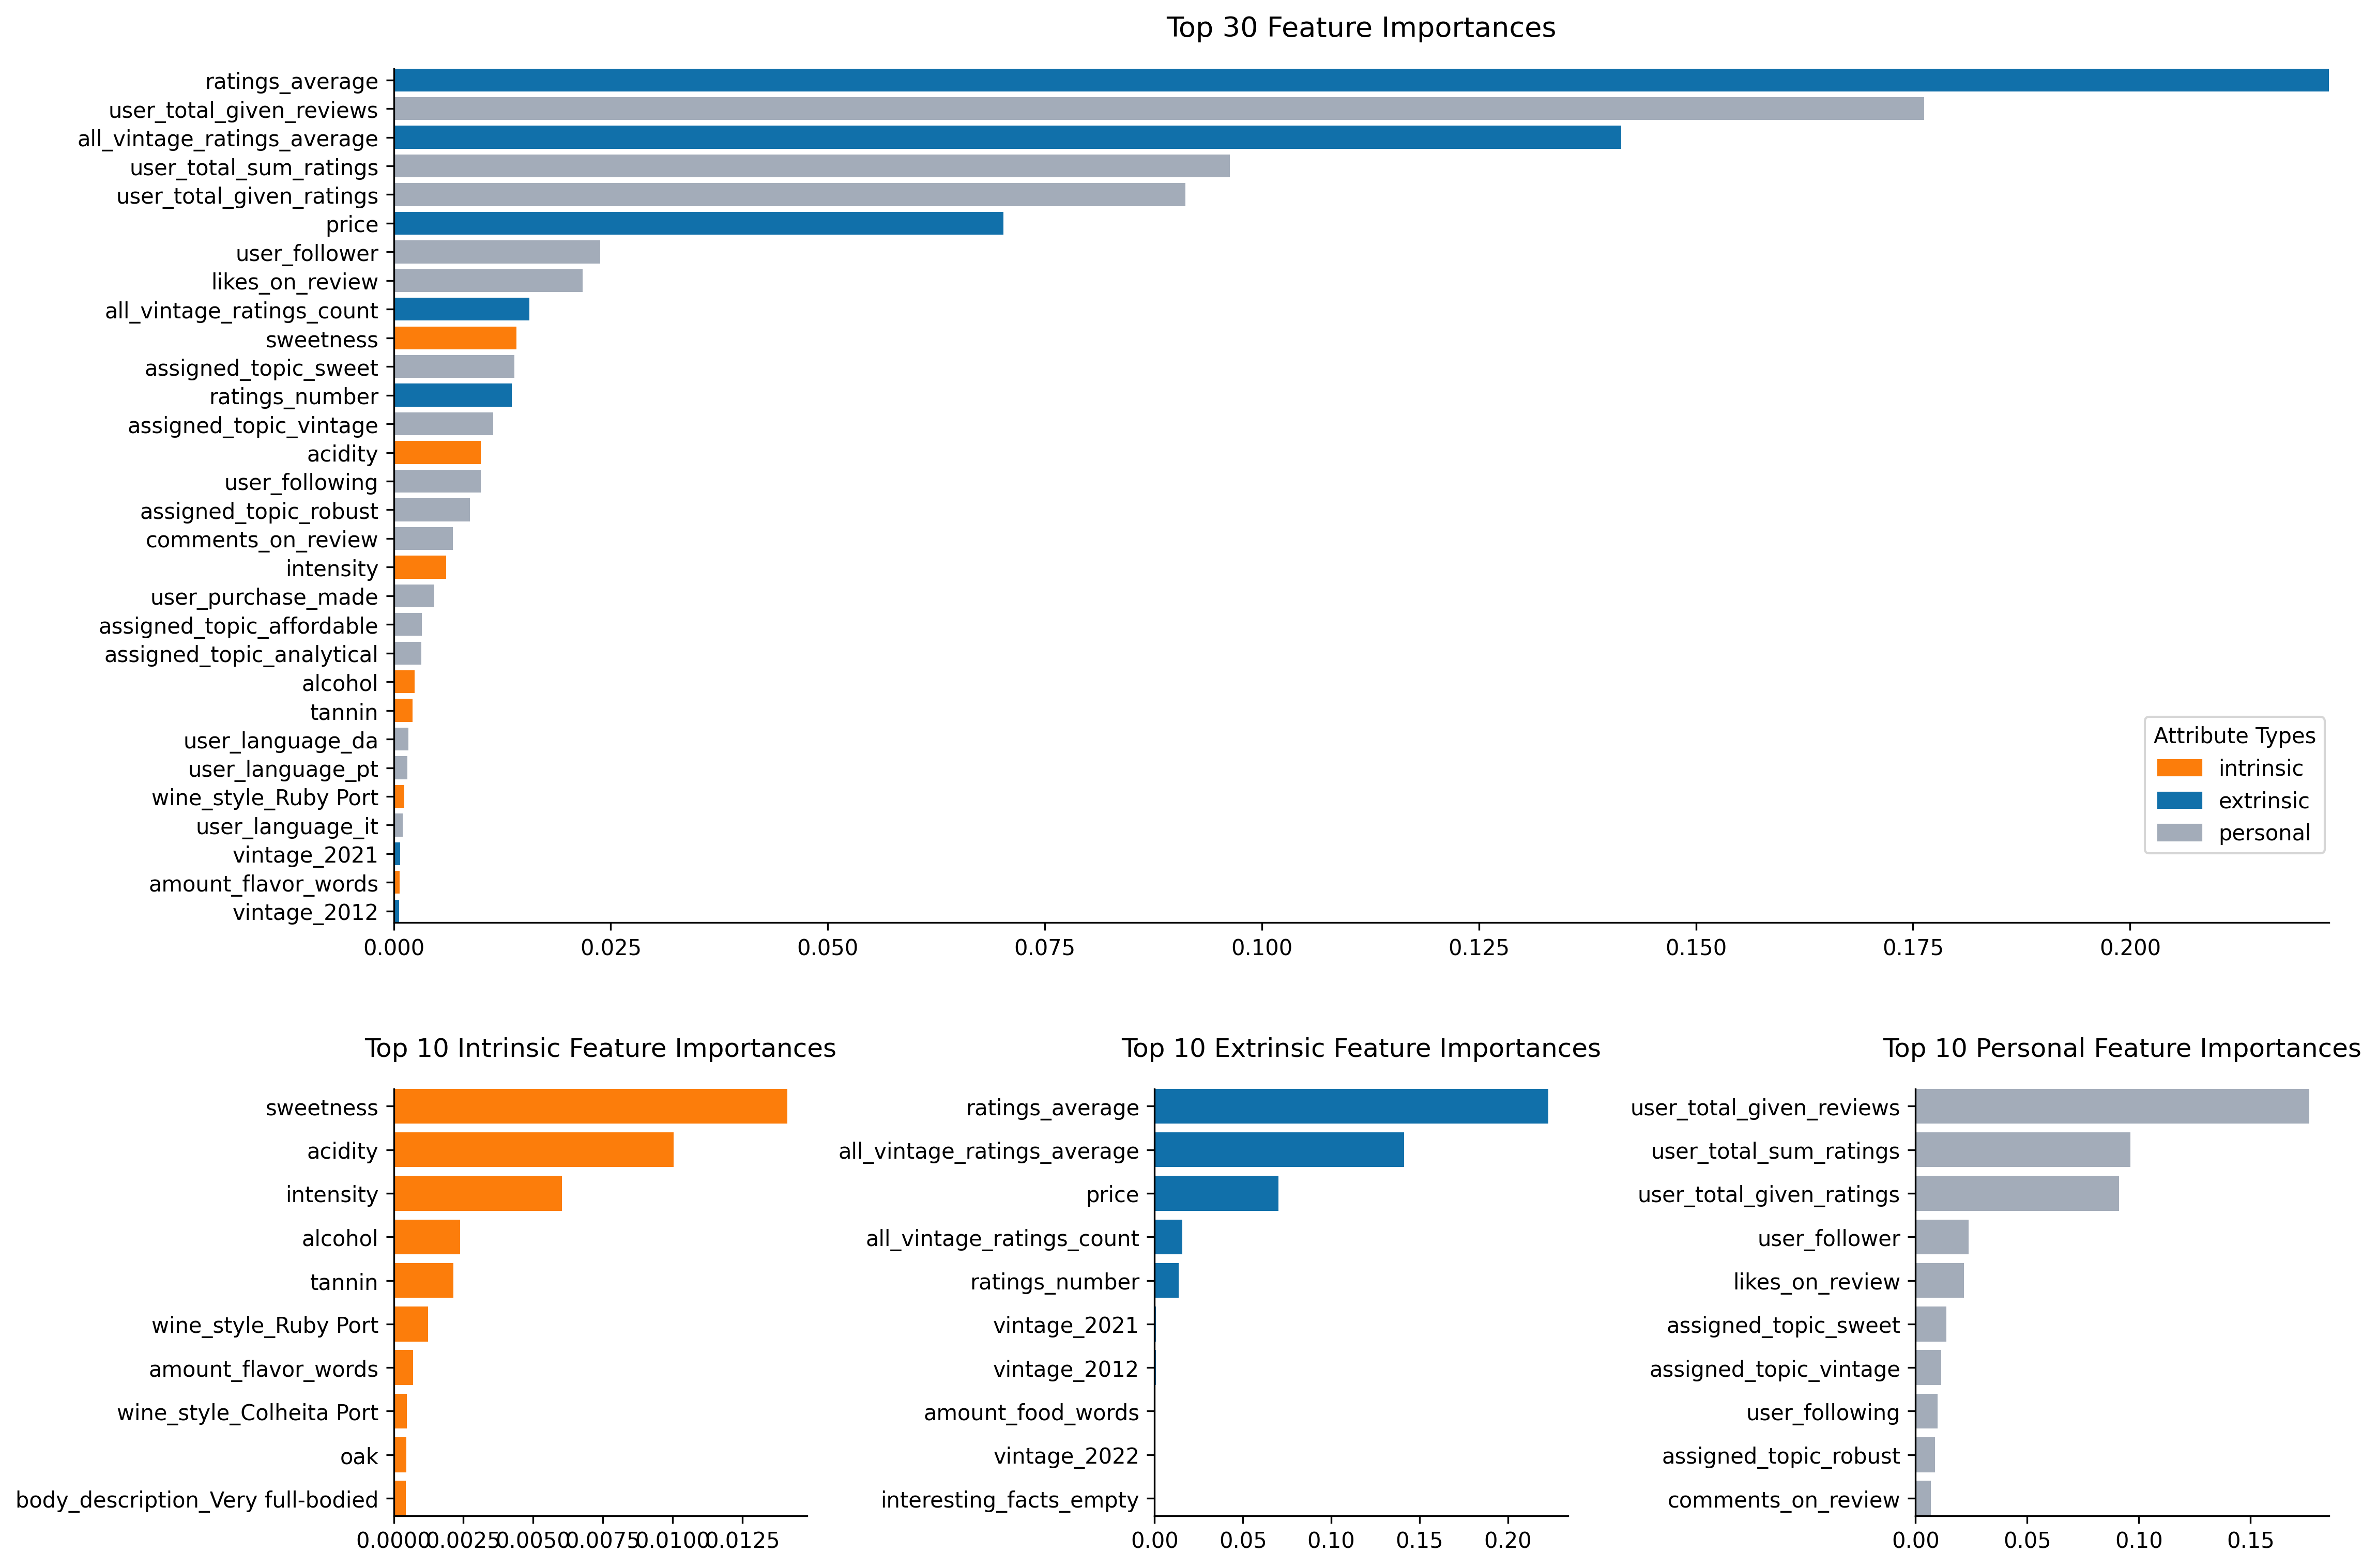

In [57]:
evaluate(gbc)

In [121]:
import optuna
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, roc_auc_score

def objective(trial):
    # Suggest values for hyperparameters
    n_estimators = trial.suggest_int("n_estimators", 30, 60) #50
    max_depth = trial.suggest_int("max_depth", 2, 10)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.2, log=True) #0.01
    subsample = trial.suggest_float("subsample", 0.6, 0.9)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20) # new parameter
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])


    params = {
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'subsample': subsample,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf, # added parameter
        'max_features': max_features
    }
    # Creating the GradientBoostingClassifier model
    model = GradientBoostingClassifier(**params)

    # Stratified K-Fold cross-validator
    skf = StratifiedKFold(n_splits=5)

    # Custom scoring function for multi-class ROC AUC
    roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True, multi_class='ovr')

    # Perform cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring=roc_auc_scorer)

    # Average ROC AUC score across all folds
    return scores.mean()

# Early stopping callback
def early_stopping_callback(study, trial):
    if study.best_trial.number + 10 <= trial.number:
        study.stop()

In [122]:
# Create a study and optimize
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, callbacks=[early_stopping_callback])

# Retrieve the best model
gradient_model = GradientBoostingClassifier(**study.best_params, random_state=0)
gradient_model.fit(X_train, y_train)

[I 2023-12-29 07:19:58,766] A new study created in memory with name: no-name-7f94d791-eb38-4c36-8d2e-cc3ea88ea413
[I 2023-12-29 07:20:53,377] Trial 0 finished with value: 0.7098914911146141 and parameters: {'n_estimators': 41, 'max_depth': 2, 'learning_rate': 0.02777175333356471, 'subsample': 0.7115108733956859, 'min_samples_split': 5, 'max_features': 'log2', 'min_samples_leaf': 3}. Best is trial 0 with value: 0.7098914911146141.
[I 2023-12-29 07:22:19,978] Trial 1 finished with value: 0.743034743733536 and parameters: {'n_estimators': 48, 'max_depth': 5, 'learning_rate': 0.012500367608412827, 'subsample': 0.605750346237812, 'min_samples_split': 12, 'max_features': 'sqrt', 'min_samples_leaf': 17}. Best is trial 1 with value: 0.743034743733536.
[I 2023-12-29 07:23:51,848] Trial 2 finished with value: 0.7455384751939691 and parameters: {'n_estimators': 58, 'max_depth': 6, 'learning_rate': 0.04497730870888012, 'subsample': 0.7644947563739026, 'min_samples_split': 5, 'max_features': 'log2'

GradientBoostingClassifier(learning_rate=0.052138177649419276, max_depth=6,
                           min_samples_leaf=9, min_samples_split=5,
                           n_estimators=60, random_state=0,
                           subsample=0.8120241153650077)

Train accuracy: 0.5259756489449067

Test accuracy: 0.4728620818927813

              precision    recall  f1-score   support

           0       0.12      0.01      0.01       130
           1       0.00      0.00      0.00        60
           2       0.11      0.02      0.04       326
           3       0.07      0.00      0.01       445
           4       0.27      0.03      0.06      2249
           5       0.41      0.28      0.33      4454
           6       0.49      0.86      0.62     10477
           7       0.44      0.20      0.28      3395
           8       0.49      0.15      0.23      2471

    accuracy                           0.47     24007
   macro avg       0.27      0.17      0.18     24007
weighted avg       0.43      0.47      0.40     24007




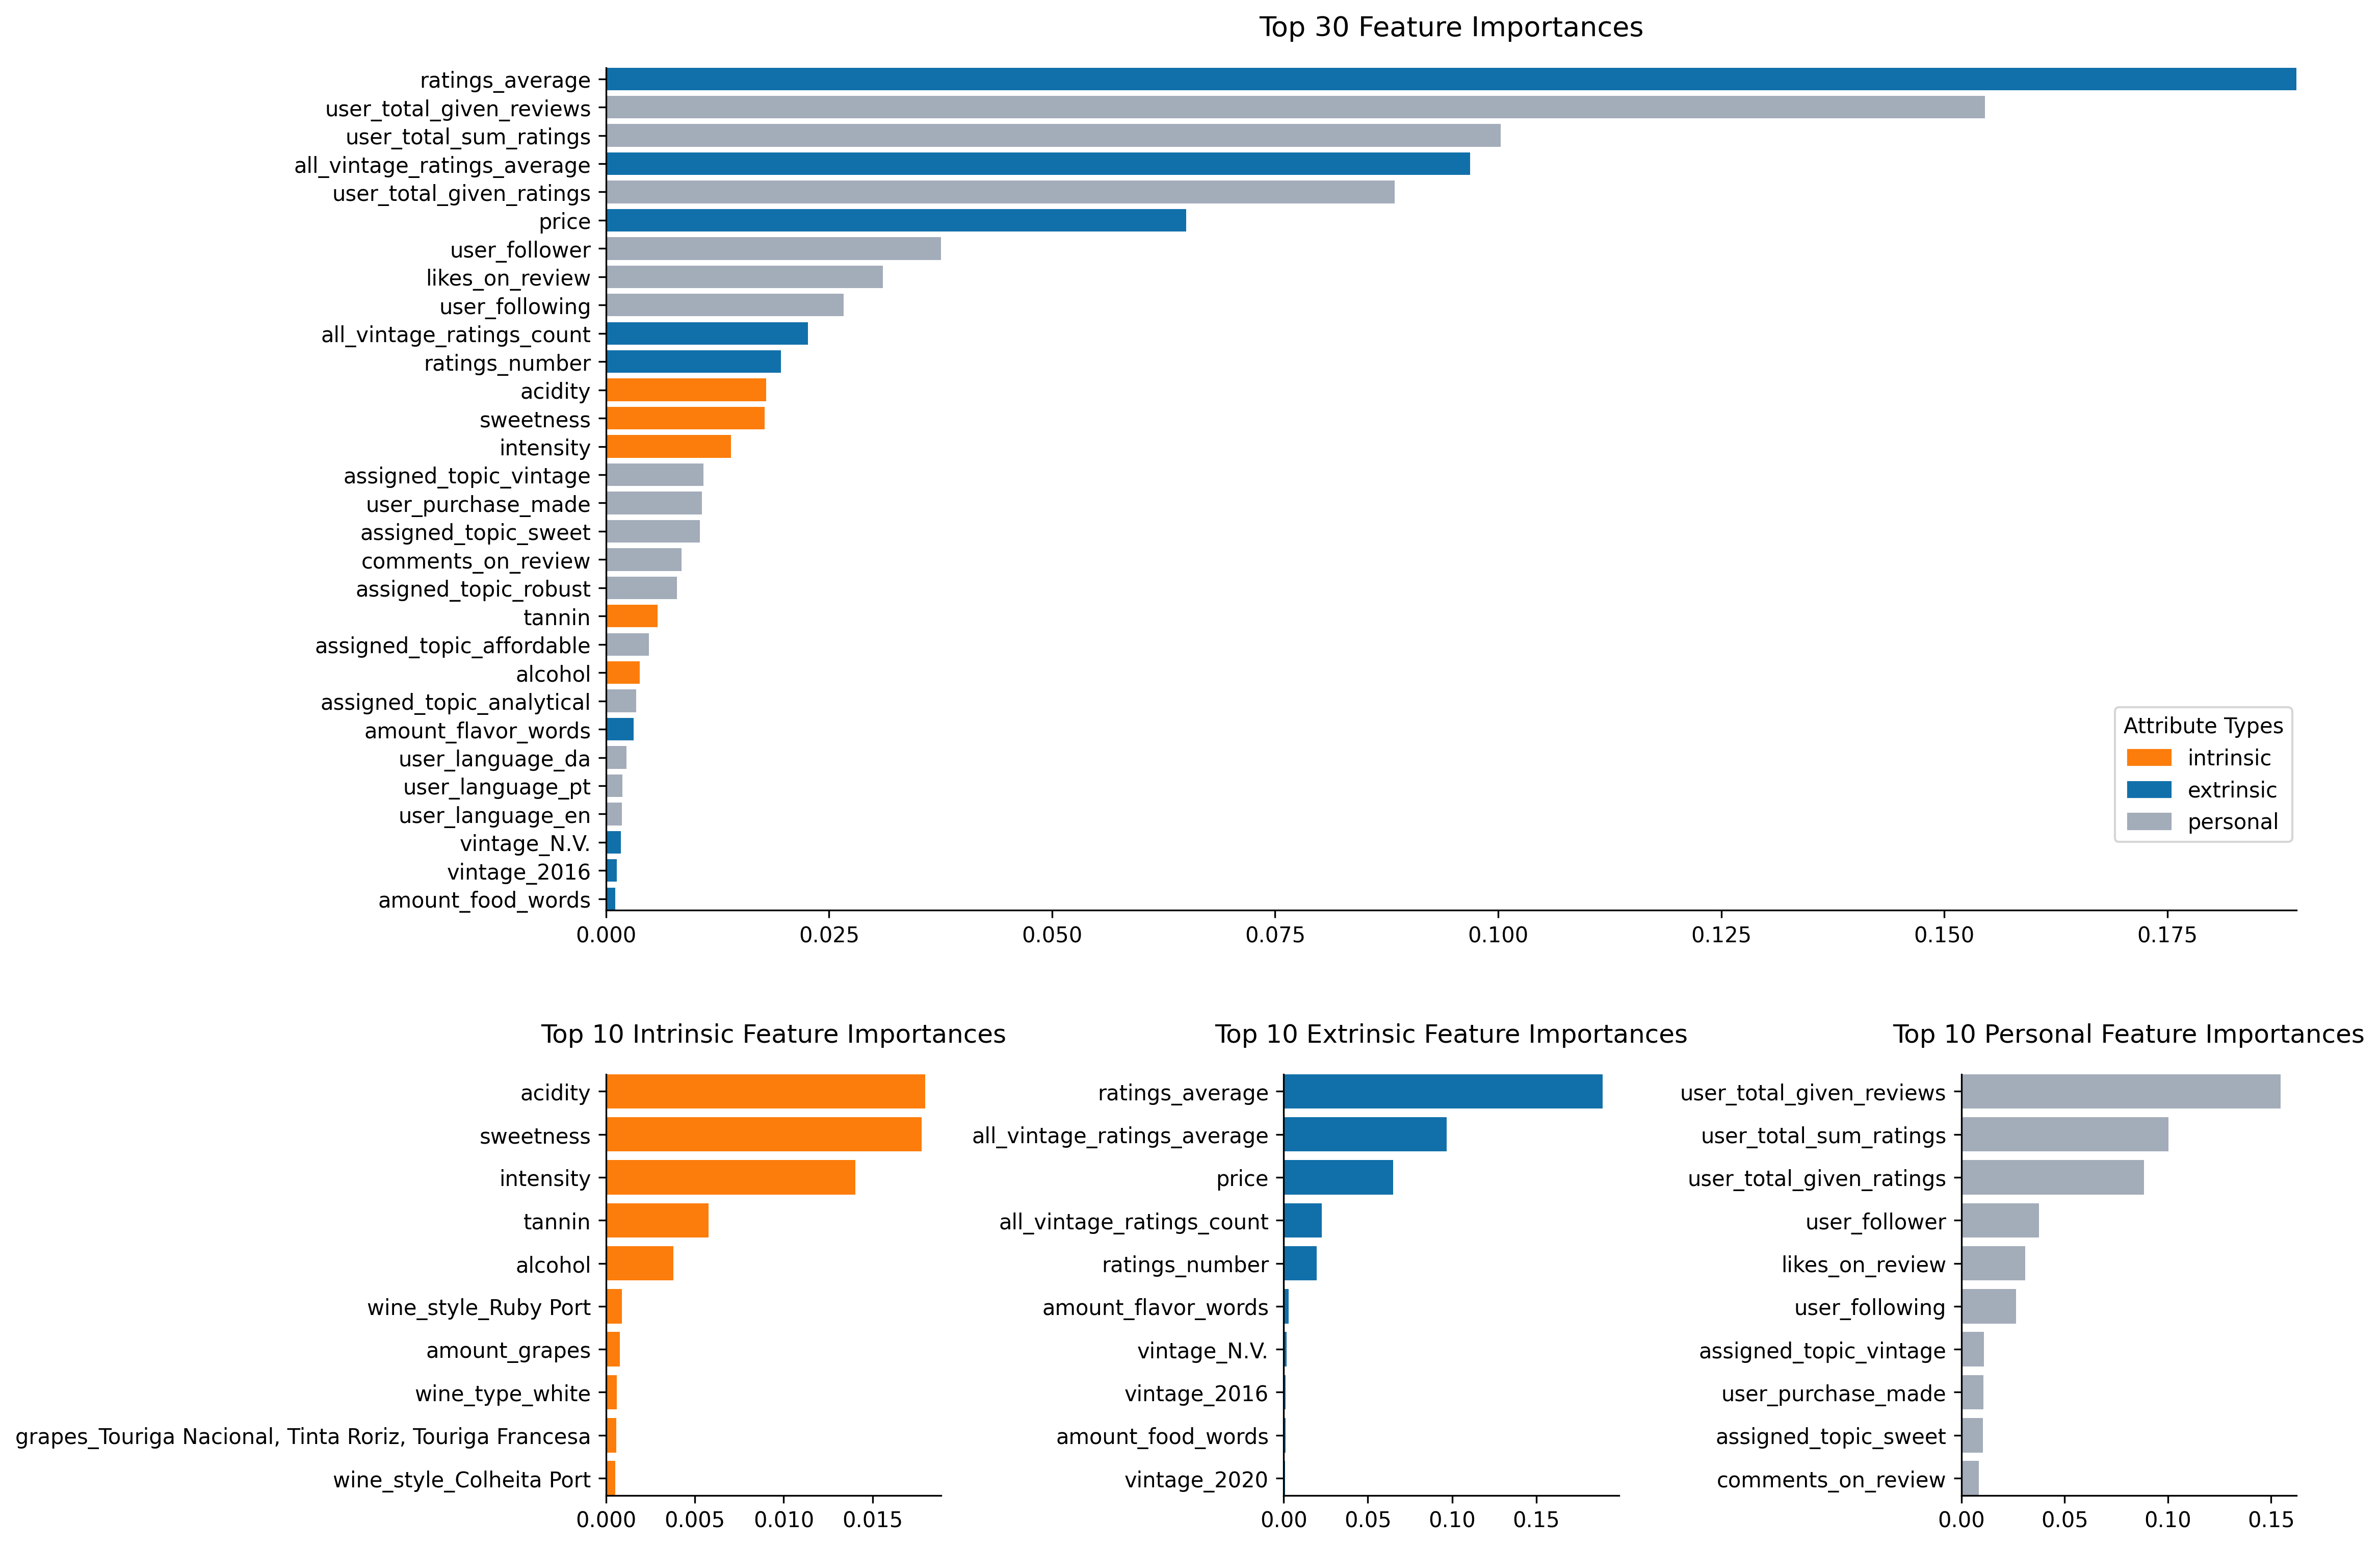

In [123]:
evaluate(gradient_model)

In [125]:
# Specify the directory name where you want to save the model
model_dir = 'Model'

# Save your model to a file within the directory
model_path = os.path.join(model_dir, 'gradient_model.joblib')
dump(gradient_model, model_path)

['Model\\gradient_model.joblib']

In [58]:
# Specify the directory name where you want to save the model
model_dir = 'Model'

model_path = os.path.join(model_dir, 'gradient_model.joblib')

gradient_loaded = load(model_path)

In [59]:
# Make predictions on the test set
y_pred_proba = gradient_loaded.predict_proba(X_test)  # Get probabilities for each class

# Calculate the ROC AUC score for multiclass classification
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

print(f"ROC AUC Score on Test Set: {roc_auc}")

ROC AUC Score on Test Set: 0.7486218414344332
